

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Conditional Generative Adversarial Networks for Subsurface Modeling: How Good They Really Are?

#### Ahmed Merzoug, PhD Student, The University of Texas at Austin
#### [LinkedIn](https://www.linkedin.com/in/ahmed-merzoug/) | [GitHub](https://github.com/amerzoug) | [GoogleScholar](https://scholar.google.com/citations?user=Ppx0Y1sAAAAJ&hl=en&oi=ao)

#### Michael Pyrcz, Associate Professor,The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


#### Work completed as part of the DIRECT consortium for Subsurface Data Analytics and Machine Learning

#### Executive Summay
Generative adversarial networks (GANs) are increasingly recognized for their potential in subsurface modeling and uncertainty quantification, thanks to their capability to learn complex geological patterns from spatial training images and their ability to perform rapid local data conditioning in a lower-dimensional latent space compared to the full-dimensional space of the images. However, the performance of these algorithms often receives acceptance based primarily on visual inspection or limited qualitative assessment. To address this, we propose a minimum acceptance criteria workflow designed to quantitatively assess and verify the adequacy of GAN-generated subsurface models. This evaluation is carried out through three key metrics: (1) reproduction of data distribution, (2) reproduction of spatial continuity, and (3) local data conditioning. 

Our proposed workflow applied to GANs trained on a variety of images from sequential Gaussian simulations demonstrates that while data distribution and spatial continuity are consistently well-reproduced, local data conditioning faces several challenges. These include increasing prediction error and the need for more iterations for conditioning as the number of conditioning data increases. Additionally, the conditioning process at these data locations tends to introduce artifacts near the data locations including high local variogram nugget effects. Our minimum acceptance criteria offer a comprehensive framework for evaluating various models ensuring a higher control on modeling quality acceptance and rejection. 

We recommend applying this workflow before using generative artificial intelligence for subsurface modeling. This avoids the ocular-based approach and provides quantitative model assessment capabilities.


#### Import required libraries 

In [1]:
import torch  # Importing PyTorch, a popular deep learning framework
import torch.nn as nn  # Importing neural network modules from PyTorch
import torch.optim as optim  # Importing optimization algorithms from PyTorch
from torch.utils.data import Dataset, DataLoader  # Importing utilities for working with datasets and data loaders in PyTorch
from torchvision import datasets, transforms  # Importing torchvision datasets and transforms for image processing
import numpy as np  # Importing NumPy for numerical operations
from PIL import Image  # Importing Python Imaging Library (PIL) for image processing
import os  # Importing os module for operating system dependent functionality (like file manipulation)
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting and visualization
from scipy.optimize import minimize  # Importing optimization function from SciPy for minimizing a function
from scipy.spatial.distance import pdist, squareform  # Importing functions for pairwise distance calculation and square form conversion
from scipy.interpolate import interp1d  # Importing interpolation function from SciPy
import geostatspy.GSLIB as GSLIB  # Importing GSLIB utilities for geostatistical visualization and wrapper functions
import geostatspy.geostats as geostats  # Importing geostatistical functions like variogram calculations
from scipy import stats  # Importing statistical functions from SciPy
import imageio  # Importing imageio for reading and writing image data
from numba import jit  # Importing JIT (just-in-time) compiler from Numba for numerical speed up
from scipy.stats import linregress  # Importing linear regression function from SciPy
from scipy.integrate import quad  # Importing numerical integration function from SciPy
import statistics  # Importing statistics module for basic statistical functions
import pandas as pd  # Importing Pandas for data manipulation and analysis


#### Loading Generator 

In [2]:
# Define the Generator network structure (pre-defined and pre-trained)
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            # Project and reshape the input noise vector
            nn.Linear(z_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),  # Reshape to (batch_size, 256, 8, 8)

            # Upsample to (batch_size, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to (batch_size, 32, 64, 64)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to (batch_size, 1, 128, 128)
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output is (batch_size, 1, 128, 128)
        )

    def forward(self, z):
        return self.net(z)

# Function to scale generated images back to the original range
def scale_to_original(generated_images, min_val, max_val, mean, std):
    # Reverse the normalization
    images = generated_images * std + mean
    # Scale back to original range
    images = images * (max_val - min_val) + min_val
    return images

# Custom transformation class to scale images to the unit interval
class ScaleToUnitInterval(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, sample):
        return (sample - self.min_val) / (self.max_val - self.min_val)

# Custom Dataset class for loading grayscale images from an npz file
class GrayscaleNPZDataset(Dataset):
    def __init__(self, npz_path, transform=None):
        data = np.load(npz_path)
        self.images = data['my_array1']
        self.scaler = ScaleToUnitInterval(np.min(self.images), np.max(self.images))
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.scaler(image)  # Scale the image pixel values to [0, 1]
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0)  # Add a channel dimension (PyTorch expects CxHxW)
        if self.transform:
            image = self.transform(image)
        return image

# Load the pre-trained Generator model
generator = Generator(z_dim=100)

# Load the state dictionary from the saved model (assuming the correct path is provided)
state_dict = torch.load('Generated Images/Gaussian/200/checkpoints/generator_epoch_6000.pth', map_location='cpu')
generator.load_state_dict(state_dict)

# Set the generator model to evaluation mode
generator.eval()

# Function to generate images using the pre-trained generator
def generateimagefunction(z):
    # Generate images without gradient computation
    with torch.no_grad():
        generated_images = generator(z).squeeze()
        
    # Apply necessary transformations to match the dataset's normalization
    transform = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))  # Assumes the data is already scaled to [0, 1]
    ])
    
    # Load the dataset to get the original scaling parameters
    dataset = GrayscaleNPZDataset('Training Images/my_data200.npz', transform=transform)
    
    # Retrieve original data statistics
    min_val_original = np.min(dataset.images)
    max_val_original = np.max(dataset.images)
    mean = 0.5  # Used in transforms.Normalize
    std = 0.5   # Used in transforms.Normalize
    
    # Scale the generated images back to the original range
    scaled_back_images = scale_to_original(generated_images, min_val_original, max_val_original, mean, std)
    scaled_back_images_np = scaled_back_images.cpu().detach().numpy()
    return scaled_back_images_np

# Initialize an empty list to store errors
errors = []

# Objective function for optimization
def objective_function(z, target_locations, target_values, iteration=[0], optres=[0]):
    # Increment the iteration count
    iteration[0] += 1

    # Convert z to a PyTorch tensor
    z_tensor = torch.from_numpy(z).float().view(1, -1)

    # Generate the image using the provided function
    generated_image = generateimagefunction(z_tensor).squeeze()

    # Calculate the total and relative errors
    total_error = 0
    for loc, target in zip(target_locations, target_values):
        total_error += abs(generated_image[loc] - target)

    # Calculate the relative error normalized by the number of points
    relative_error = total_error / np.sum(np.abs(target_values)) 
    
    optres.fun = relative_error
    optres.genimage = generated_image
    optres.iteration = iteration[0]
    optres.zoptimum = z

    # Early stopping check
    if relative_error < 0.01:
        raise StopIteration(f"Early stopping criterion met at iteration {iteration[0]} - Total Error: {total_error:.2f}, Relative Error: {relative_error:.4f}")
    
    return relative_error


#### Define Subsurface Minimum Acceptance Checks 

To ensure the validity and accuracy of the generated images, several minimum acceptance checks are implemented. The first check involves comparing the univariate porosity distribution of the GAN-generated images with that of the associated training images. This is done by quantitatively analyzing the overlap between the distributions of the generated and training images. The overlap is reported as the overlapping area, which indicates the degree of similarity between the histograms. This area is then normalized by dividing it by the area of the original data distribution to calculate the overlapping percentage, as described by Inman and Bradley (1989). A percentage closer to 100% signifies a greater similarity between the distributions.

To further compare the distributions, Q-Q plots are employed, which cross-plot the quantiles of the GAN model distribution against those of the training images. If the distributions are similar, the points on the Q-Q plot will align closely with the line y=x. For a more quantitative comparison, a method similar to the Lorenz coefficient is adapted, as suggested by Peters (2012). This involves fitting a piecewise linear function to the Q-Q plot and integrating the absolute difference between this function and the y=x line to estimate the area between them. The smaller this area, the more similar the distributions.

In addition to univariate comparisons, two-point statistics are used to compare the spatial structure of the GAN-generated images with that of the training images by analyzing their variograms. The variograms of both sets of images are plotted together, and the overlap between them indicates the degree of similarity in spatial continuity.

In [3]:
# Function to calculate the variogram of a given dataset
def calculate_variogram(data, dx, dy, nlag):
    lag_distance, vario, npairs = geostats.gam(
        data, tmin=-9999, tmax=9999, xsiz=10, ysiz=10,
        ixd=2, iyd=0, nlag=31, isill=1.0
    )
    return lag_distance, vario, npairs

# Function to calculate overlap area between histograms of two images
def overlaparea(Training_Images, generated_image):
    hist1, bins = np.histogram(Training_Images.squeeze()[np.random.randint(0, 100), :, :].flatten(), bins=50, range=(min(Training_Images.squeeze()[1, :, :].flatten()), max(Training_Images.squeeze()[np.random.randint(0, 100), :, :].flatten())), density=True)
    hist2, _ = np.histogram(generated_image.flatten(), bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    return overlap


# Function to calculate overlap area between histograms of two images
def overlaparea(Training_Images, generated_image):
    hist1, bins = np.histogram(Training_Images.squeeze()[np.random.randint(0, 100), :, :].flatten(), bins=50, range=(min(Training_Images.squeeze()[1, :, :].flatten()), max(Training_Images.squeeze()[np.random.randint(0, 100), :, :].flatten())), density=True)
    hist2, _ = np.histogram(generated_image.flatten(), bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    return overlap


# Function to normalize data to [0, 1] range
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


# Function to calculate total absolute area between two samples
def calculate_total_absolute_area(sample1, sample2):
    sample1_normalized = min_max_normalize(sample1)
    sample2_normalized = min_max_normalize(sample2)
    quantiles1 = np.percentile(sample1_normalized, np.linspace(0, 100, 100))
    quantiles2 = np.percentile(sample2_normalized, np.linspace(0, 100, 100))

    slopes = []
    intercepts = []
    for i in range(len(quantiles1) - 1):
        slope, intercept, _, _, _ = linregress([quantiles1[i], quantiles1[i+1]], [quantiles2[i], quantiles2[i+1]])
        slopes.append(slope)
        intercepts.append(intercept)

    def segment_linear_fit(x, index):
        return slopes[index] * x + intercepts[index]

    def calculate_absolute_area_under_segment(index):
        area = quad(lambda x: abs(segment_linear_fit(x, index) - x), quantiles1[index], quantiles1[index+1])[0]
        return area

    total_absolute_area = sum(calculate_absolute_area_under_segment(i) for i in range(len(slopes)))
    return total_absolute_area

# Function to calculate the average variance around specified points in an image
def calculate_average_variance_around_points(generated_image, target_locations):
    variances = []
    for (x, y) in target_locations:
        neighboring_values = [generated_image[x, y]]  # Include the value at (x, y)
        if x > 0:
            neighboring_values.append(generated_image[x-1, y])
        if x < generated_image.shape[0] - 1:
            neighboring_values.append(generated_image[x+1, y])
        if y > 0:
            neighboring_values.append(generated_image[x, y-1])
        if y < generated_image.shape[1] - 1:
            neighboring_values.append(generated_image[x, y+1])
        
        if neighboring_values:
            variances.append(np.var(neighboring_values))

    return np.mean(variances) if variances else 0

# Function to calculate variance for all pixels in an image
def calculate_variance_for_all_pixels(image):
    variance_map = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            neighboring_values = [image[x, y]]  # Include the value at (x, y)
            if x > 0:
                neighboring_values.append(image[x-1, y])
            if x < image.shape[0] - 1:
                neighboring_values.append(image[x+1, y])
            if y > 0:
                neighboring_values.append(image[x, y-1])
            if y < image.shape[1] - 1:
                neighboring_values.append(image[x, y+1])

            variance_map[x, y] = np.var(neighboring_values)
    return variance_map.mean()

# Function to calculate variance away from conditioned points in an image
def calculate_neighbor_variance_away_from_conditioned(generated_image, conditioned_points, lag):
    variances = []

    for x in range(generated_image.shape[0]):
        for y in range(generated_image.shape[1]):
            if all(np.sqrt((x - cx)**2 + (y - cy)**2) > lag for cx, cy in conditioned_points):
                neighboring_values = [generated_image[x, y]]  # Include the value at (x, y)
                if x > 0:
                    neighboring_values.append(generated_image[x-1, y])
                if x < generated_image.shape[0] - 1:
                    neighboring_values.append(generated_image[x+1, y])
                if y > 0:
                    neighboring_values.append(generated_image[x, y-1])
                if y < generated_image.shape[1] - 1:
                    neighboring_values.append(generated_image[x, y+1])

                if neighboring_values:
                    variances.append(np.var(neighboring_values))

    return np.mean(variances) if variances else 0

# Function to calculate indices for specified locations in an image
def indexingfunction(z, locations):
    flattened_indices = []

    for location in locations:
        x, y = location
        if x < 2 or y < 2 or x > 126 or y > 126:
            continue  # Skip this location

        indexx = []
        indexy = []
        II = 1
        IY = 1

        for s in np.arange(4):
            if z[x-2+s, y] < z[x-1+s, y]:
                indexx.append(1)
            else:
                indexx.append(0)

        for j in np.arange(4):
            II += indexx[j] * 2 ** j

        for s in np.arange(4):
            if z[x, y-2+s] < z[x, y-1+s]:
                indexy.append(1)
            else:
                indexy.append(0)

        for j in np.arange(4):
            IY += indexy[j] * 2 ** j

        flattened_indices.extend([II, IY])

    return flattened_indices


#Entropy Calculation Function
def calculate_pixelwise_entropy(images):
    # Assuming images is of shape (N, H, W) where
    # N is the number of images, H and W are the height and width of the images.
    
    # Initialize an array to hold the entropy values for each pixel position
    entropy_matrix = np.zeros((images.shape[1], images.shape[2]))
    
    # Iterate over each pixel position
    for i in range(images.shape[1]):  # Iterate over the height
        for j in range(images.shape[2]):  # Iterate over the width
            # Extract the pixel values at position (i, j) across all images
            pixel_values = images[:, i, j]
            
            # Quantize the pixel values to 256 levels
            pixel_values_quantized = (pixel_values * 255).astype(np.uint8)
            
            # Calculate the frequency of each pixel value
            pixel_frequency = np.bincount(pixel_values_quantized, minlength=256)
            pixel_frequency = pixel_frequency[pixel_frequency > 0]  # Remove zeros
            
            # Calculate probabilities
            probabilities = pixel_frequency / len(pixel_values_quantized)
            
            # Calculate entropy for this pixel position
            entropy = -np.sum(probabilities * np.log2(probabilities))
            entropy_matrix[i, j] = entropy
    
    return entropy_matrix


def normalize_to_first_index(arrays):
    normalized_arrays = []
    if len(arrays) > 0 and len(arrays[0]) > 0:
        # Convert the first array to a numpy array and calculate its mean
        reference_mean = np.percentile(np.array(arrays[0]),50)
        for arr in arrays:
            # Ensure arr is a numpy array before performing operations
            arr_np = np.array(arr)
            normalized_arr = (arr_np - reference_mean) / reference_mean*100
            normalized_arrays.append(normalized_arr)
    else:
        # If the first array is empty or not present, return the original list of arrays
        return arrays
    return normalized_arrays


def generate_non_conditioned_realizations(Training_Images,num_realizations=50):
    non_cond_variograms = []
    non_cond_OA = []
    non_cond_Area = []
    non_cond_Var=[]

    for _ in range(num_realizations):
        initial_z = np.random.randn(100)
        z_tensor = torch.from_numpy(initial_z).float().view(1, -1)
        generated_image = generateimagefunction(z_tensor).squeeze()

        # Calculate metrics for non-conditioned realization
        nlagy,vario, nobed  = geostats.gam(
        generated_image, tmin=-9999, tmax=9999, xsiz=7.8125, ysiz=7.8125,
        ixd=2, iyd=0, nlag=15, isill=1.0
        )  # Implement this function

      
   
        non_cond_overlap_area = overlaparea(Training_Images, generated_image)
        non_cond_total_area = calculate_total_absolute_area(Training_Images, generated_image)

        non_cond_variograms.append(vario[-2]-1)
        non_cond_OA.append(non_cond_overlap_area)
        non_cond_Area.append(non_cond_total_area)
        non_cond_Var.append(calculate_variance_for_all_pixels(generated_image))

        
    return non_cond_variograms, non_cond_OA, non_cond_Area, non_cond_Var



### Pattern-Based Approach to Investigate Artifacts in Realizations Near Conditioning Data

To investigate the existence of artifacts in realizations near conditioning data, specifically data conditioning as local minima or maxima, we analyze five consecutive points near the conditioned data $z(u)$. The following locations are used: $z(u-2)$, $z(u-1)$, $z(u)$, $z(u+1)$, and $z(u+2)$. 

The near data patterns are quantified using an indicator transform:

$$
i_k = 
\begin{cases} 
1, & \text{if } z(u+k) \leq z(u+k-1) \\
0, & \text{otherwise}
\end{cases}

$$


The indicators are summarized as an index that varies from 1 to 16. Figure 7 illustrates the different indexes and their corresponding patterns. If the distribution of the indexes is uniform, there are no local minima or maxima conditioning artifacts. The index is calculated as follows:

$$
\text{Index} = 1 + \sum_{j=1}^{4} i_j \cdot 2^{(j-1)} 
$$


where $i$ is the list of the four indicators $i_k$ and $j$ is the indicator identifier $\{1, 2, 3, 4\}$.




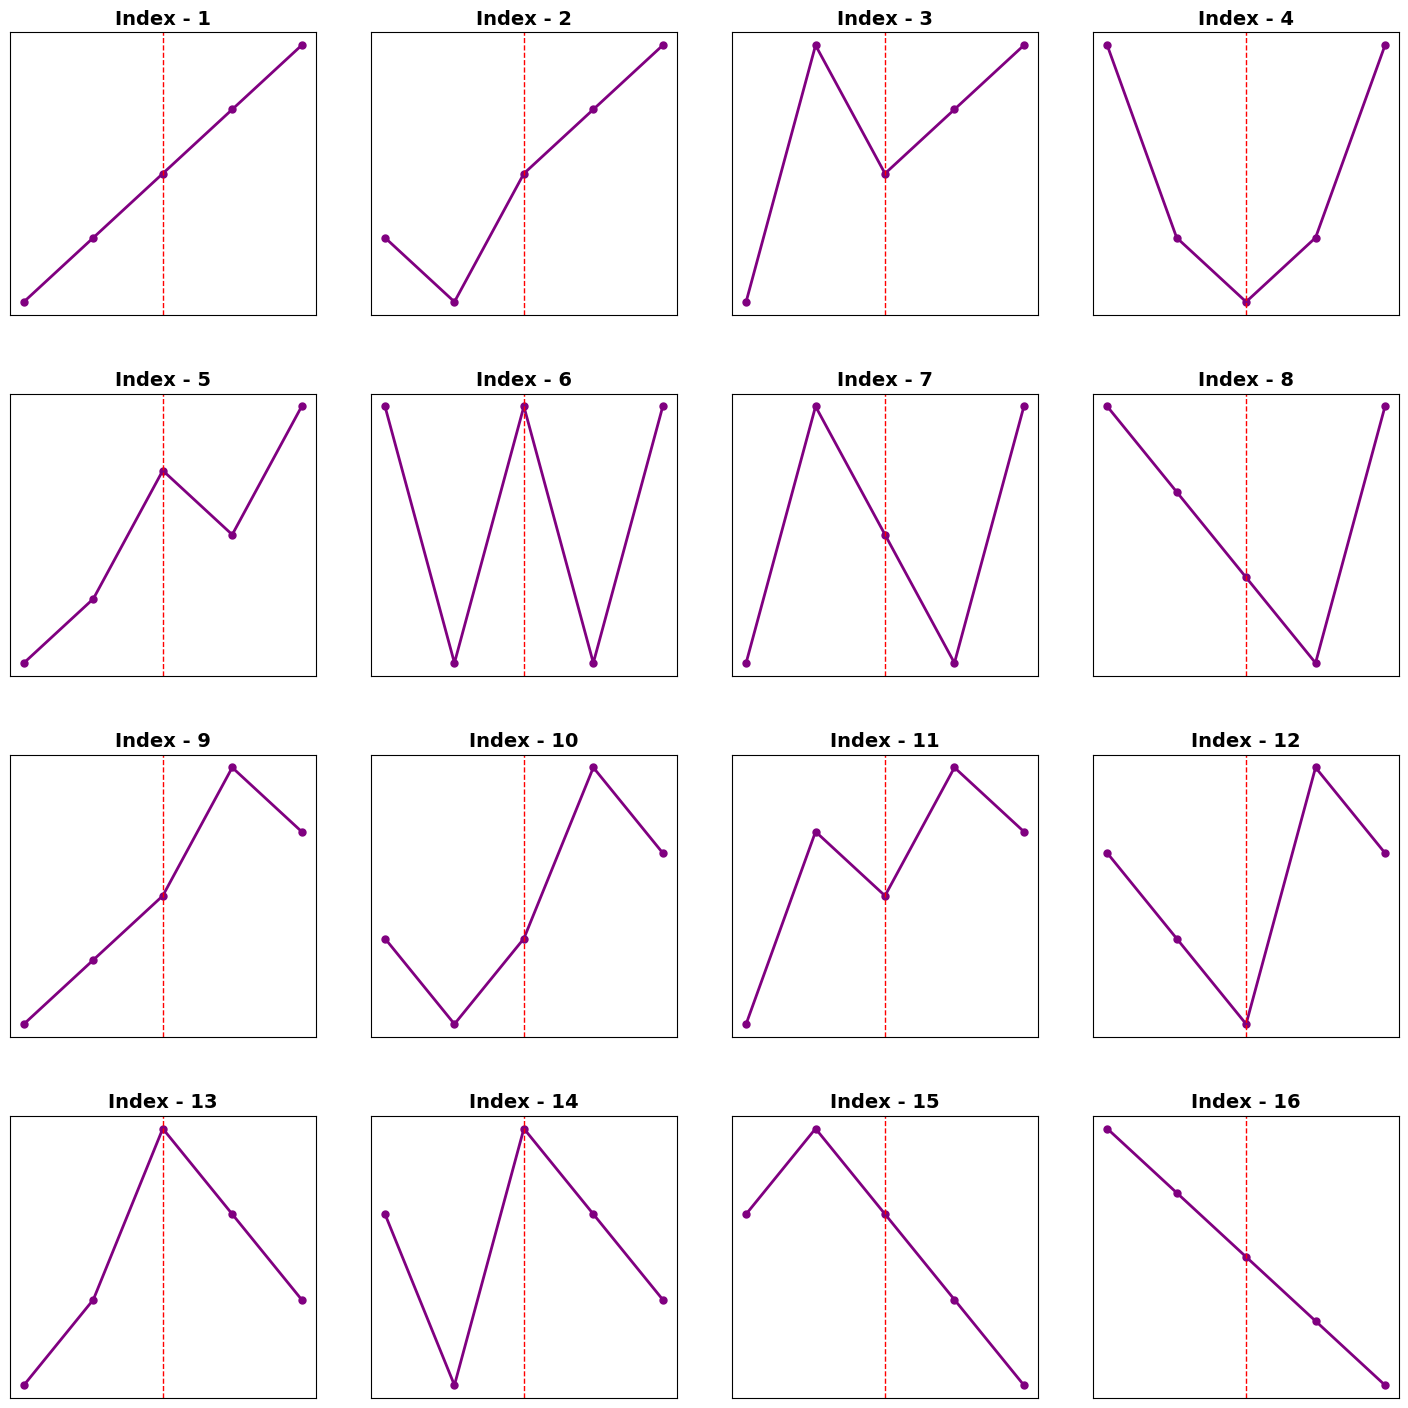

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Simulated data from the user's message structured as a CSV string for demonstration purposes
data = """
1,2,3,4,5
2,1,3,4,5
1,5,3,4,5
5,2,1,2,5
1,2,4,3,5
5,4,5,4,5
1,5,3,1,5
5,4,3,2,5
1,2,3,5,4
3,2,3,5,4
1,4,3,5,4
4,3,2,5,4
1,2,4,3,2
3,1,4,3,2
3,4,3,2,1
5,4,3,2,1
"""

# Read the data into a DataFrame
df = pd.read_csv(StringIO(data), header=None)

# Improved plot setup
fig, axs = plt.subplots(4, 4, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')

# Flatten the axis array for easy iteration and indexing
axs = axs.flatten()

# Plot each line in a separate subplot with the specified improvements
# Plot each line in a separate subplot with the specified improvements
for index, row in df.iterrows():
    # Plot with purple color and remove both x-axis and y-axis ticks and labels
    axs[index].plot(row, marker='o', linestyle='-', linewidth=2, markersize=5, color='purple')
    axs[index].set_title(f'Index - {index + 1}', fontsize=14, fontweight='bold')
    axs[index].tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    axs[index].axvline(x=2, color='red', linestyle='--', linewidth=1)
    axs[index].grid(False)  # Remove grid
# Adjust layout to prevent overlap
plt.tight_layout(pad=4.0)

# Show plot
plt.show()



#### Functions Section
Functions used during the worflow to calculate and plot results from classical DTW algorithm and physics constrain DTW

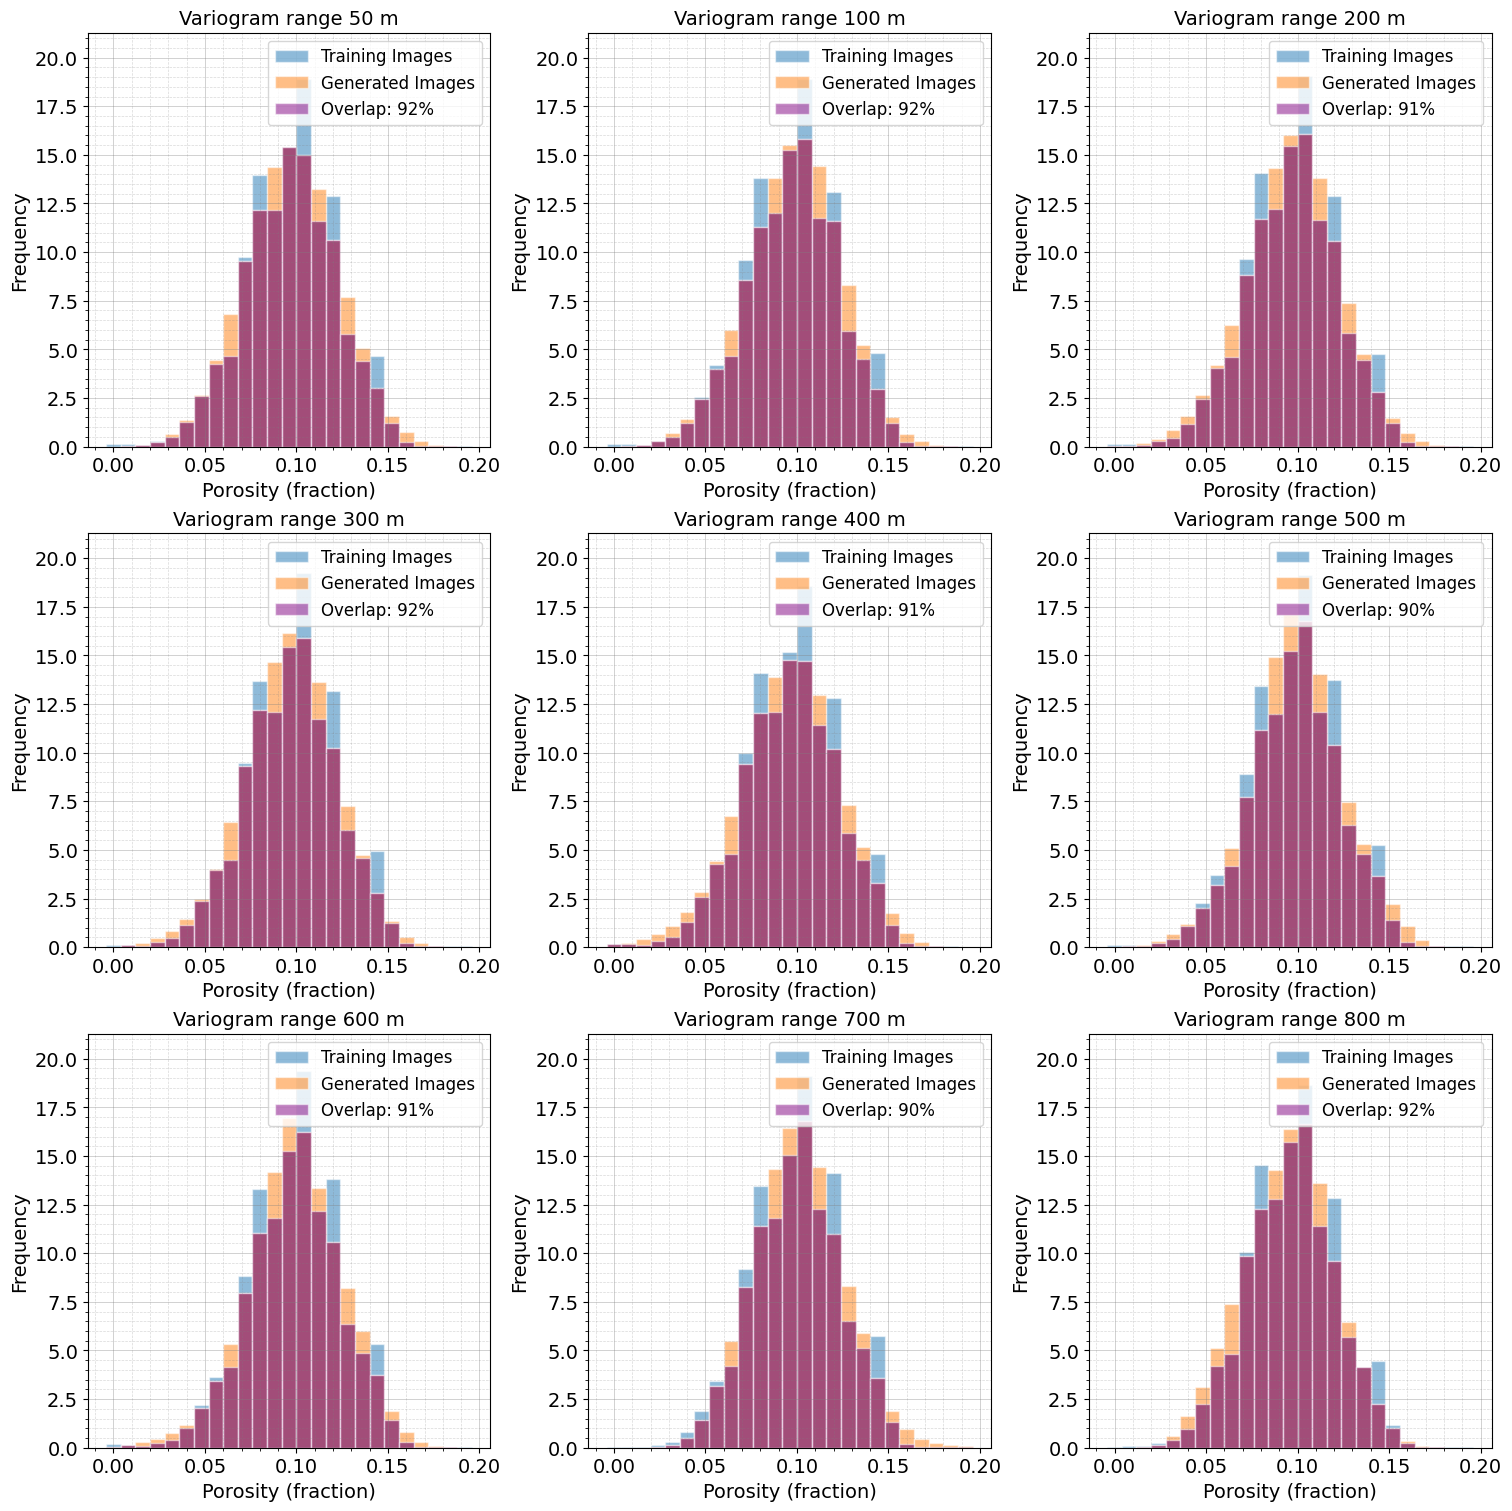

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Define the epochs to loop over
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Histogram range and bins
hist_range = (0, 0.2)  # Adjust this range based on your data's values
bins = 25

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()

# Initialize a variable to track the maximum y-value
max_y_val = 0

for i, epoch in enumerate(epochs):
    new_data_path = f'Training Images/my_data{epoch}.npz'
    Training_ = np.load(new_data_path)
    Training_I = [Training_[key] for key in Training_]
    Training_Images= np.stack(Training_I).squeeze()
    data1 = Training_Images.reshape(Training_Images.shape[0], -1).flatten()
    epoch_data_path = f'Generated Images/Gaussian/{epoch}/epoch_8000.npz'
    epoch_data = np.load(epoch_data_path)
    epoch_images = [epoch_data[key] for key in epoch_data]
    combined_epoch_tensor = np.stack(epoch_images).squeeze()
    data2 = combined_epoch_tensor.reshape(combined_epoch_tensor.shape[0], -1).flatten()

    # Create normalized histograms for both distributions
    hist1, bins = np.histogram(data1, bins=bins, range=hist_range, density=True)
    hist2, _ = np.histogram(data2, bins=bins, range=hist_range, density=True)
    bin_width = np.diff(bins)

    # Calculate the overlapping area
    overlap = np.sum(np.minimum(hist1, hist2) * bin_width)
    total_area_new_data = np.sum(hist1 * bin_width)
    overlap_percentage = (overlap / total_area_new_data) * 100

    # Plot both histograms and the overlapping area in the subplot
    axs[i].bar(bins[:-1], hist1, width=bin_width, alpha=0.5, edgecolor='white', label='Training Images')
    axs[i].bar(bins[:-1], hist2, width=bin_width, alpha=0.5, edgecolor='white', label=f'Generated Images')
    overlap_area = np.minimum(hist1, hist2)
    axs[i].bar(bins[:-1], overlap_area, width=bin_width, color='purple', edgecolor='white', alpha=0.5)

    # Set titles and labels for the subplot
    axs[i].set_title(f'Variogram range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('Porosity (fraction)', fontsize = 14)
    axs[i].set_ylabel('Frequency', fontsize = 14)

    # Update max_y_val if necessary
    max_y_val = max(max_y_val, max(hist1.max(), hist2.max()))

    # Adding overlap percentage to the legend
    overlap_label = f'Overlap: {overlap_percentage:.0f}%'
    handles, labels = axs[i].get_legend_handles_labels()
    handles.append(plt.Rectangle((0, 0), 1, 1, fc="purple", edgecolor='white', alpha=0.5))  # Create a custom legend handle
    labels.append(overlap_label)
    axs[i].legend(handles, labels, fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)



# Set the same y-axis limit for all subplots after determining the maximum y-value
for ax in axs:
    ax.set_ylim(0, max_y_val * 1.1)  # Slightly above the max value for visual clarity

plt.show()


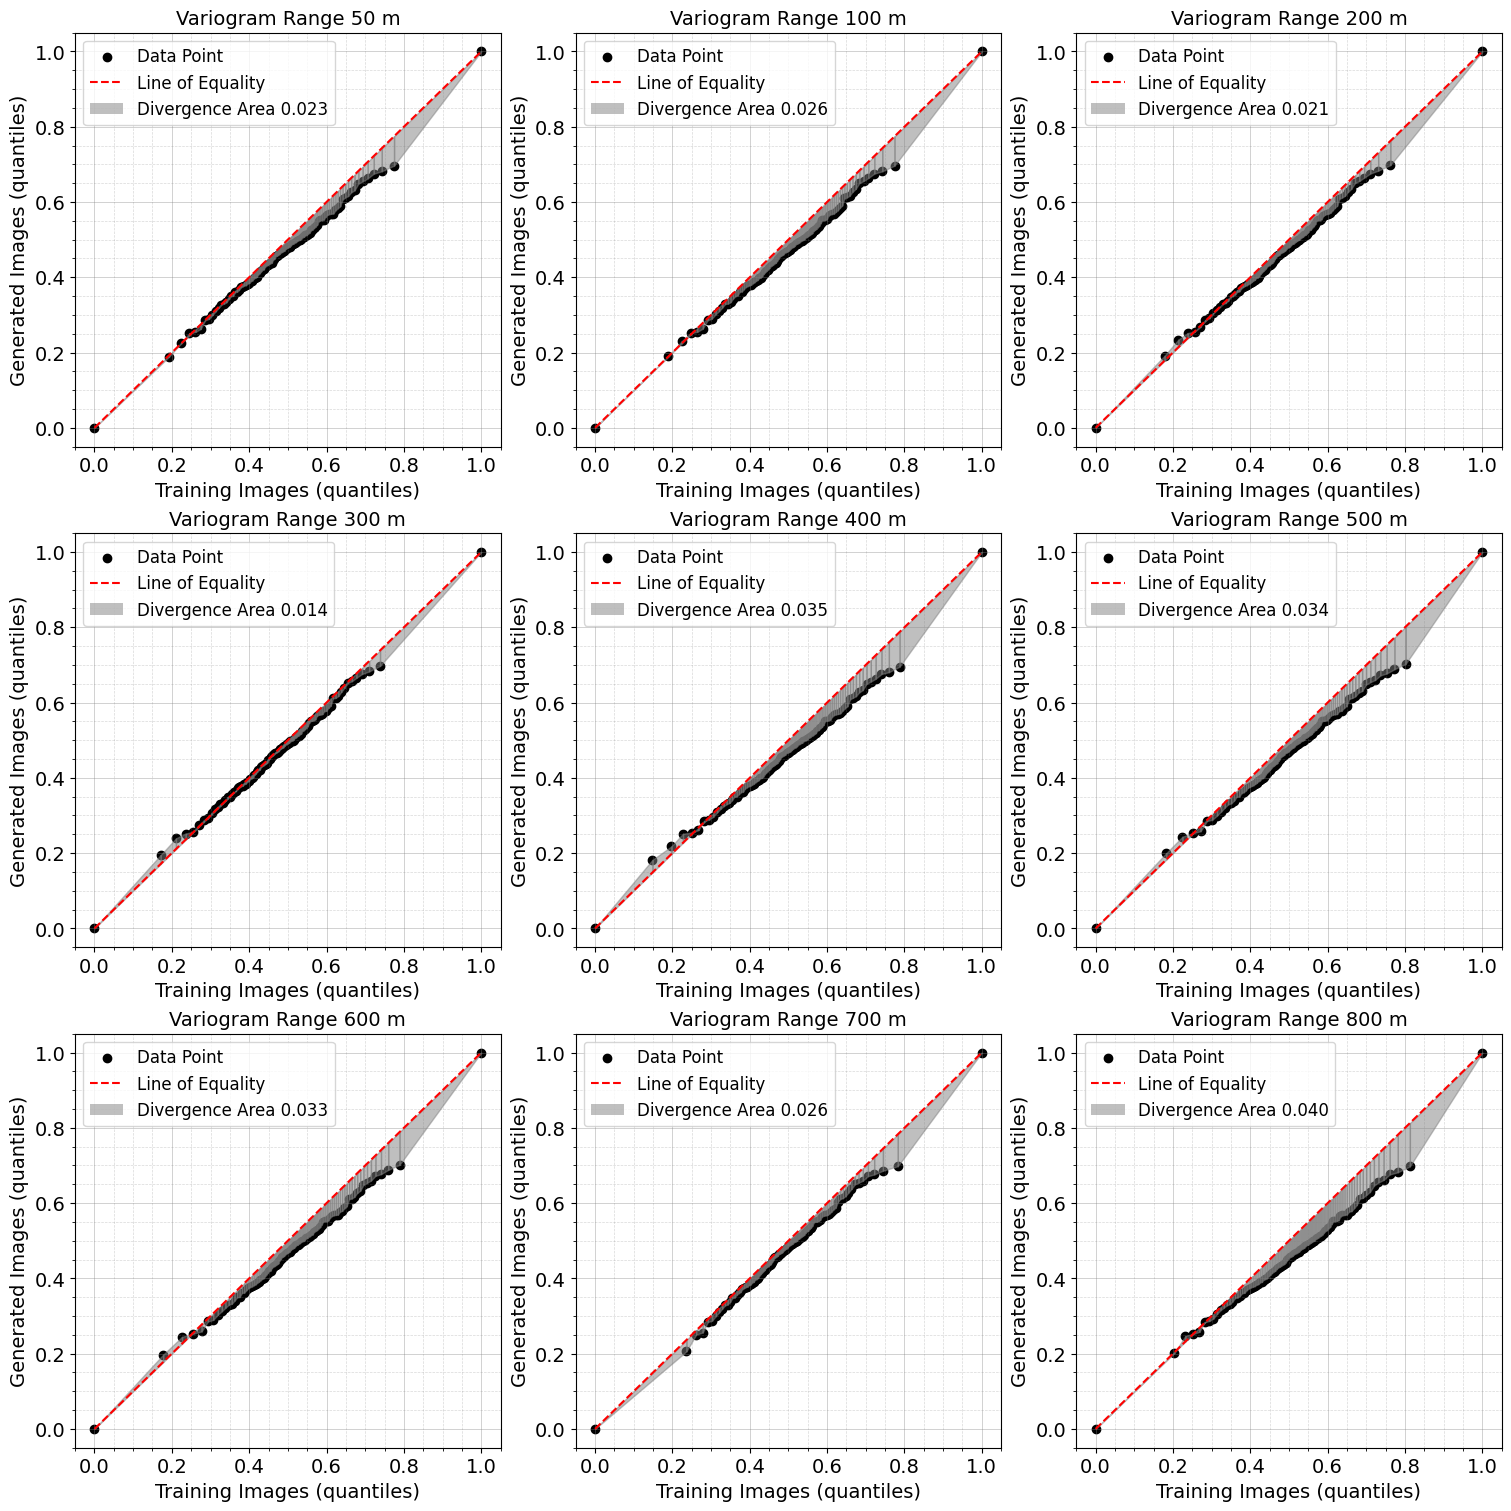

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.integrate import quad

# Define the epochs to loop over
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()

def calculate_slopes_intercepts(quantiles1, quantiles2):
    slopes = []
    intercepts = []
    for i in range(len(quantiles1) - 1):
        slope, intercept, _, _, _ = linregress([quantiles1[i], quantiles1[i+1]], [quantiles2[i], quantiles2[i+1]])
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

def segment_linear_fit(x, index, slopes, intercepts):
    return slopes[index] * x + intercepts[index]

def calculate_absolute_area_under_segment(index, quantiles1, slopes, intercepts):
    area = quad(lambda x: abs(segment_linear_fit(x, index, slopes, intercepts) - x), quantiles1[index], quantiles1[index+1])[0]
    return area

def load_and_prepare_data(epoch):
    data = np.load(f'Generated Images/Gaussian/{epoch}/epoch_8000.npz')
    images = [data[key] for key in data]
    Generated_Images = np.stack(images).squeeze()

    Training_ = np.load(f'Training Images/my_data{epoch}.npz')
    Training_I = [Training_ [key] for key in Training_ ]
    Training_Images = np.stack(Training_I).squeeze()

    def min_max_normalize(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    sample1 = min_max_normalize(Generated_Images.reshape(-1))
    sample2 = min_max_normalize(Training_Images.reshape(-1))
    quantiles1 = np.percentile(sample1, np.linspace(0, 100, 100))
    quantiles2 = np.percentile(sample2, np.linspace(0, 100, 100))
    return quantiles1, quantiles2

for i, epoch in enumerate(epochs):
    quantiles1, quantiles2 = load_and_prepare_data(epoch)
    slopes, intercepts = calculate_slopes_intercepts(quantiles1, quantiles2)
    total_absolute_area = sum(calculate_absolute_area_under_segment(i, quantiles1, slopes, intercepts) for i in range(len(slopes)))

    axs[i].scatter(quantiles1, quantiles2, color='black', label='Data Point')
    min_quantile, max_quantile = min(quantiles1), max(quantiles2)
    axs[i].plot([min_quantile, max_quantile], [min_quantile, max_quantile], 'r--', label='Line of Equality')

    # Shading the area that is further from the 45-degree line
    for j in range(len(slopes)):
        x_segment = np.linspace(quantiles1[j], quantiles1[j+1], 100)
        y_segment_fit = segment_linear_fit(x_segment, j, slopes, intercepts)
        axs[i].fill_between(x_segment, x_segment, y_segment_fit, where=(y_segment_fit > x_segment), color='grey', alpha=0.5, interpolate=True)
        axs[i].fill_between(x_segment, y_segment_fit, x_segment, where=(y_segment_fit < x_segment), color='grey', alpha=0.5, interpolate=True)

    axs[i].set_title(f'Variogram Range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('Training Images (quantiles)', fontsize = 14)
    axs[i].set_ylabel('Generated Images (quantiles)', fontsize = 14)
    divergence_label = f'Divergence Area {total_absolute_area:.3f}'
    total_area_label = f'Total Absolute Area: {total_absolute_area:.3f}'
    handles, labels = axs[i].get_legend_handles_labels()
    handles.append(plt.Rectangle((0,0),1,1,fc='grey', edgecolor='none', alpha=0.5))  # Add custom handle for divergence area
    labels.append(divergence_label)
    labels.append(total_area_label)
    axs[i].legend(handles, labels, loc='upper left',fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()


#### Image Checking at Low Dimensional Space 

Given the high dimensionality of image data, dimensionality reduction techniques like Multidimensional Scaling (MDS) and Linear Discriminant Analysis (LDA) are applied to facilitate comparison. MDS is used to project the high-dimensional image data into a 2D space, where the degree of separation between the training and GAN-generated images provides insights into their similarity and underlying structure. LDA, on the other hand, reduces the data to a one-dimensional space by maximizing class separability, allowing the comparison of the resulting histograms of training and GAN-generated images. The overlap between these histograms serves as a measure of similarity, with greater overlap indicating a closer resemblance.

c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppres

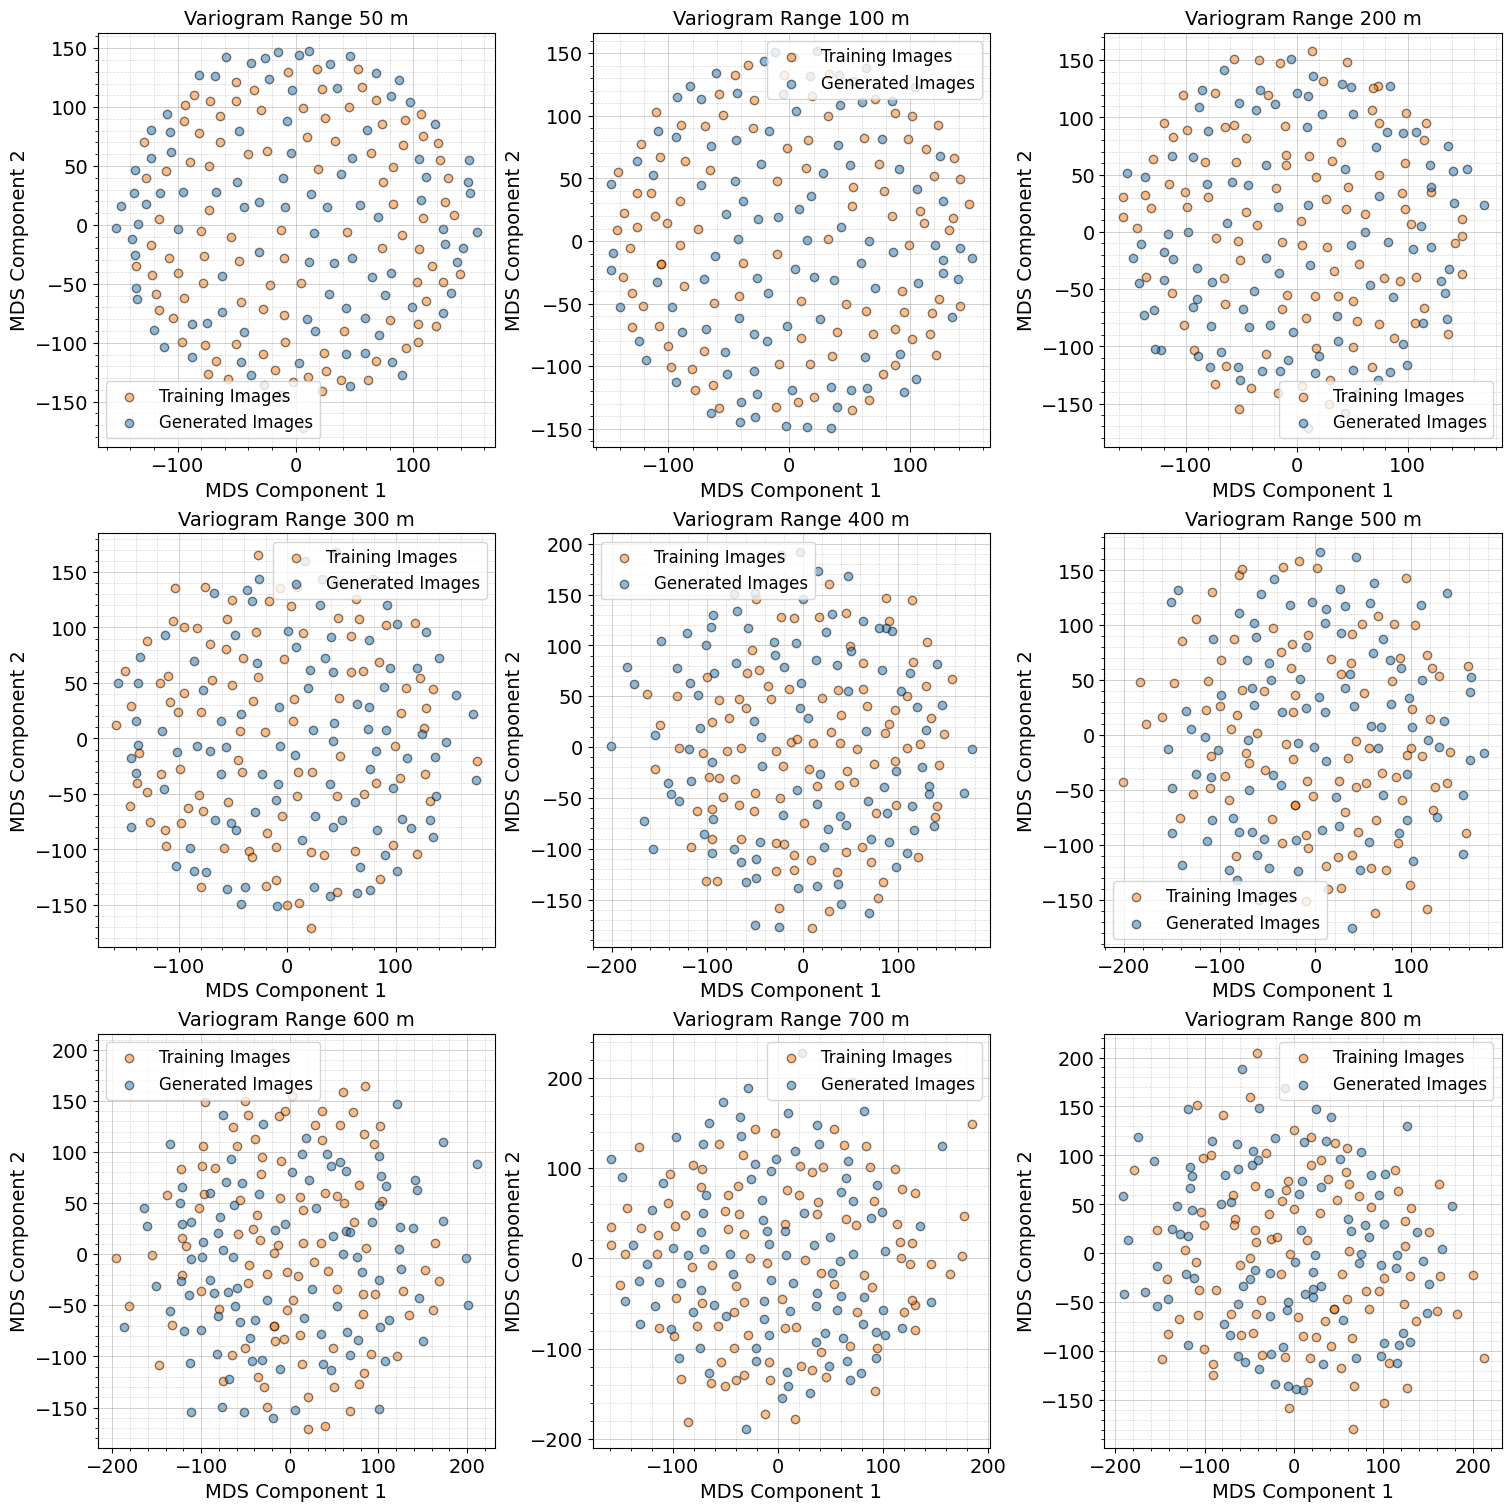

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Select the epochs for the 3x3 grid
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()  # Flatten the axis for easy iteration

for i, epoch in enumerate(epochs):

    # Load the constant new data
    new_data = np.load(f'Training Images/my_data{epoch}.npz')
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()
    new_data_flat = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1)

    # Initialize the scaler and standardize the new data
    scaler = StandardScaler()
    new_data_flat = scaler.fit_transform(new_data_flat)
    file_path = f'Generated Images/Gaussian/{epoch}/epoch_8000.npz'
    
    data = np.load(file_path)
    images = [data[key] for key in data]
    combined_tensor = np.stack(images).squeeze()
    data_flat = combined_tensor.reshape(combined_tensor.shape[0], -1)
    
    # Standardize the epoch data using the same scaler as the new data
    data_flat = scaler.transform(data_flat)
    
    # Combine the new data and epoch data
    combined_data = np.vstack((new_data_flat, data_flat))
    
    # Compute the dissimilarity (distance) matrix using Euclidean distances
    dissimilarity_matrix = pairwise_distances(combined_data, metric='euclidean')
    
    # Perform MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', metric=True, random_state=42)
    mds_transformed_data = mds.fit_transform(dissimilarity_matrix)
    
    # Plotting
    axs[i].scatter(mds_transformed_data[:new_data_flat.shape[0], 0], mds_transformed_data[:new_data_flat.shape[0], 1], c='C1', label='Training Images',alpha=0.5, edgecolors='k')
    axs[i].scatter(mds_transformed_data[new_data_flat.shape[0]:, 0], mds_transformed_data[new_data_flat.shape[0]:, 1], c='C0', label='Generated Images',alpha=0.5, edgecolors='k')
    
    axs[i].set_title(f'Variogram Range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('MDS Component 1',fontsize = 14)
    axs[i].set_ylabel('MDS Component 2',fontsize = 14)
    axs[i].legend(fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()


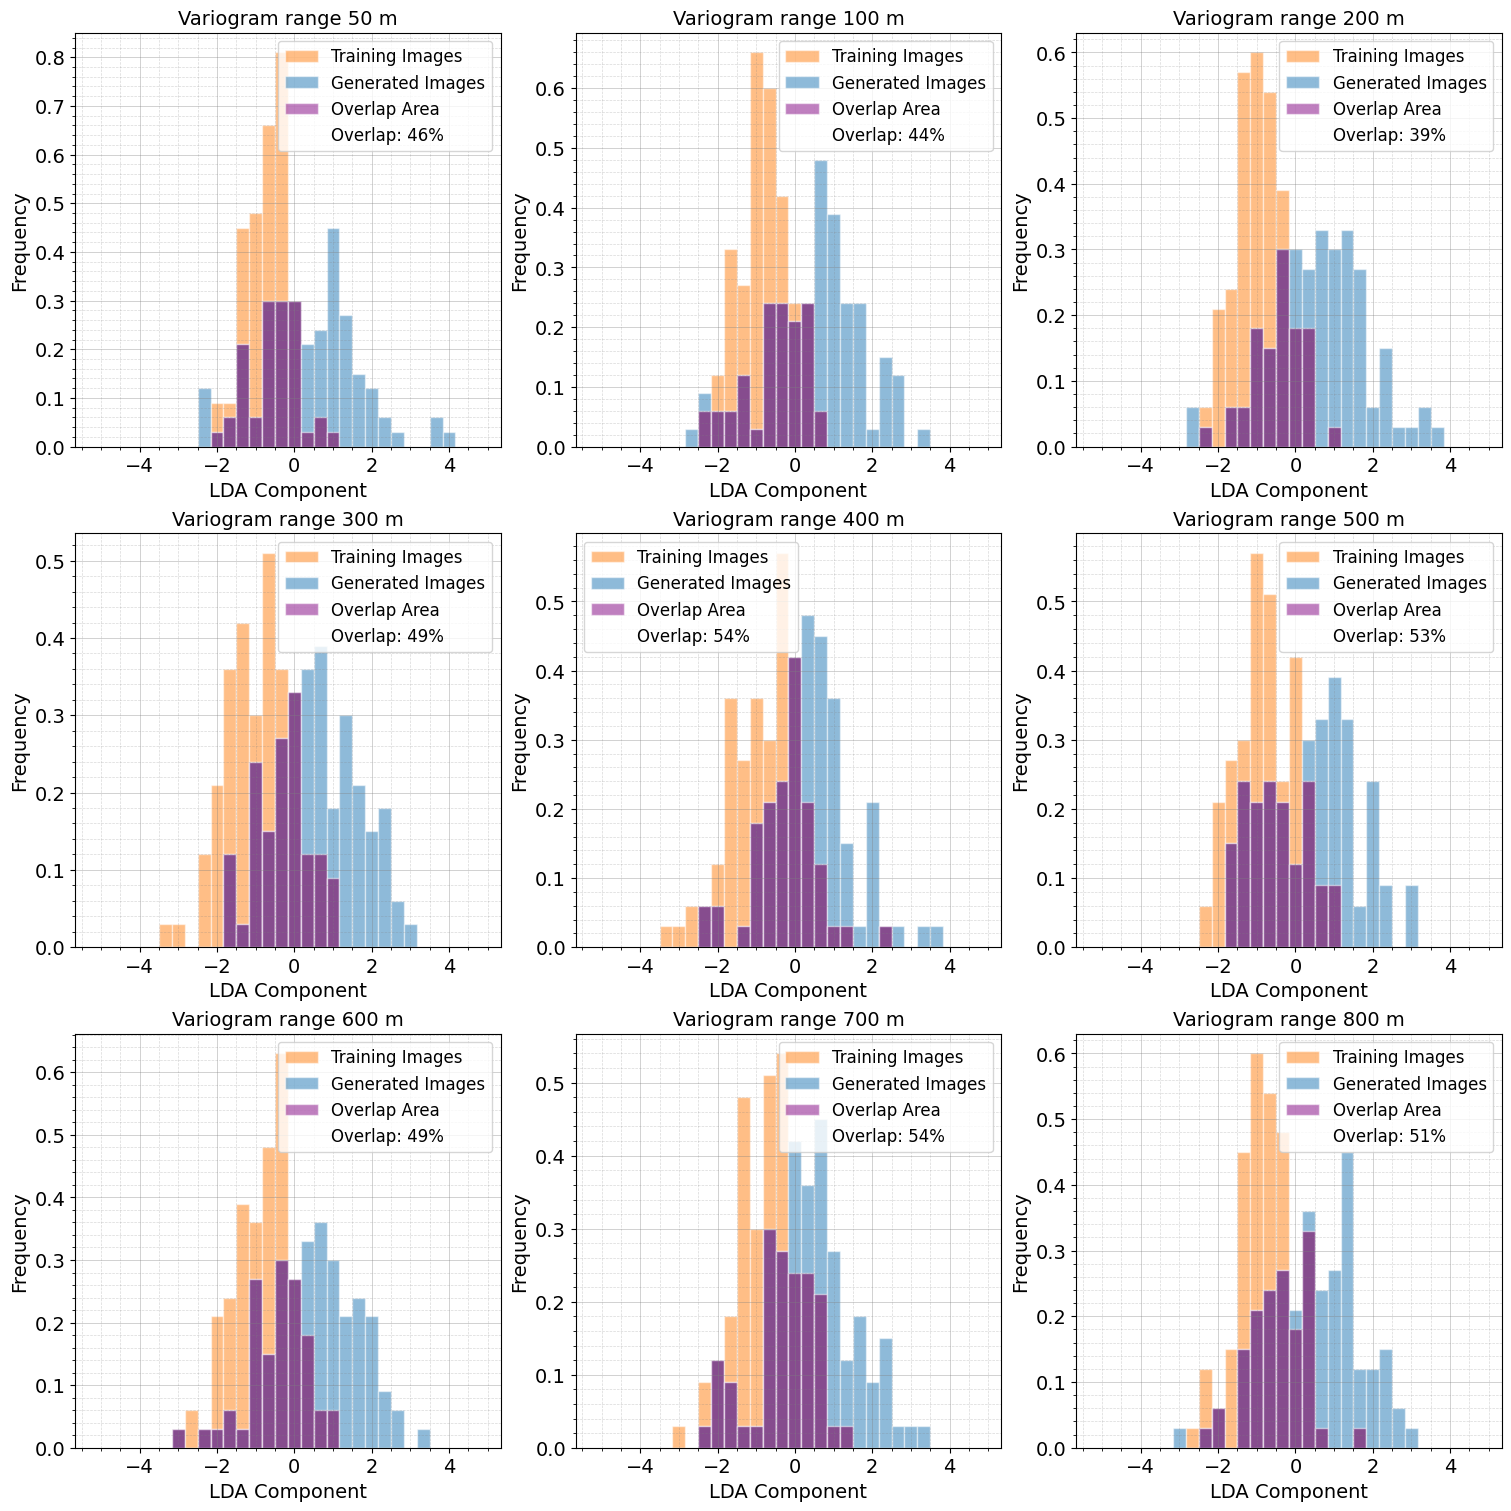

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt



# Select the epochs for the 3x3 grid
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Determine consistent bins across all histograms
bins = np.linspace(-5, 5, 31)

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)

for i, epoch in enumerate(epochs):
    row = i // 3
    col = i % 3

        # Load the constant new data
    new_data = np.load(f'Training Images/my_data{epoch}.npz')
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()
    new_data_flat = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1)

    # Initialize the scaler and standardize the new data
    scaler = StandardScaler()
    new_data_flat = scaler.fit_transform(new_data_flat)

    
    file_path = f'Generated Images/Gaussian/{epoch}/epoch_8000.npz'
    
    data = np.load(file_path)
    images = [data[key] for key in data]
    combined_tensor = np.stack(images).squeeze()
    data_flat = combined_tensor.reshape(combined_tensor.shape[0], -1)
    
    data_flat = scaler.transform(data_flat)
    
    labels = np.hstack((np.zeros(data_flat.shape[0]), np.ones(new_data_flat.shape[0])))
    
    lda = LDA(n_components=1)
    lda.fit(np.vstack(( new_data_flat,data_flat)), labels)
    
    data_lda = lda.transform(data_flat)
    new_data_lda = lda.transform(new_data_flat)
    
    # Calculate the overlapping area
    hist1, bin_edges = np.histogram(data_lda, bins=bins, density=True)
    hist2, _ = np.histogram(new_data_lda, bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    bin_width = np.diff(bins)
    # Normalize the overlap by the new data area
    new_data_area = np.sum(hist2 * np.diff(bins))
    normalized_overlap = overlap / new_data_area
    
    for b in range(len(bins)-1):
        axs[row, col].bar(bins[b], hist2[b], width=bin_width[b], color='C1', edgecolor='white', alpha=0.5, label='Training Images' if b == 0 else "")
        axs[row, col].bar(bins[b], hist1[b], width=bin_width[b], color='C0', edgecolor='white', alpha=0.5, label='Generated Images' if b == 0 else "")
        
        
        # Determine and color the overlapping area in purple
        overlap_height = min(hist1[b], hist2[b])
        axs[row, col].bar(bins[b], overlap_height, width=bin_width[b], color='purple', edgecolor='white', alpha=0.5, label='Overlap Area' if b == 0 else "")

    
    # Set titles and labels
    axs[row, col].set_title(f'Variogram range {epoch} m', fontsize = 14)
    axs[row, col].set_xlabel('LDA Component',fontsize = 14)
    axs[row, col].set_ylabel('Frequency', fontsize = 14)
    axs[row, col].tick_params(axis='both', which='major', labelsize=14)
    
    # Calculate and display normalized overlap (you might want to adjust this calculation for your needs)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    new_data_area = np.sum(hist2 * np.diff(bins))
    normalized_overlap = overlap / new_data_area*100
    overlap_label = f'Overlap: {normalized_overlap:.0f}%'
    
    # Update the legend with overlap information
    handles, labels = axs[row, col].get_legend_handles_labels()
    handles.append(plt.Line2D([], [], color='none', label=overlap_label))
    axs[row, col].legend(handles=handles,fontsize = 12)
    axs[row, col].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[row, col].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[row, col].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()


### Conditioning Process 


We condition subsurface models to match local data at specific locations. The locations and corresponding data values are selected randomly from training images, which represent prior knowledge or simulations of the subsurface. The conditioning is done for different numbers of data locations, allowing the code to explore how varying the amount of data impacts the accuracy and quality of the conditioned models. For each specified number of data locations, the process is repeated multiple times (n times), generating a set of subsurface models that are consistent with the selected data. After each run, various statistics are calculated, such as the variance around the data locations, the variance away from these locations, and measures of spatial correlation like the variogram. Additionally, the overlap area between the generated models and the original training data is computed, along with the total absolute area difference. These statistics help assess the effectiveness of the conditioning process and provide insights into how well the generated models match the local data while maintaining realistic spatial patterns.

In [9]:
# Constants for the optimization and simulation
mean = 0.1
std_dev = 0.025

# Class to store the result of the optimization process
class OptimizationResult:
    def __init__(self):
        self.fun = None            # Store the value of the objective function
        self.genimage = None       # Store the generated image/result
        self.iteration = None      # Store the number of iterations
        self.zoptimum = None       # Store the optimal solution (latent variables)

# Configuration and initialization for the simulation runs
num_runs = 100  #This is the number of repeating runs. we used a large number to remove any stochasticity 
normalized_relative_average_errors = []
average_iterations = []
average_variances = []
average_neighbor_variances_away = []
average_variograms = []
max_lag = 128
num_bins = 25
lag_distance = 10

# Lists to collect results from all runs
all_errors = []
all_iterations = []
all_variances = []
all_neighbor_variances_away = []
all_variograms = []
all_OA = []
all_Area = []
latents = []
realisations = []

# Generate initial non-conditioned realizations
a, b, c, d = generate_non_conditioned_realizations(Training_Images=Training_Images)
all_variograms.append(a)
all_OA.append(b)
all_Area.append(c)
all_neighbor_variances_away.append(d)
all_variances.append(d)

# Function to extract values from the original realization (ORi) at specified locations
def get_values_from_ORi(ORi, locations):
    return [ORi[loc] for loc in locations]

# Generate random locations for the conditioning points
all_locations = [(np.random.randint(0, 126), np.random.randint(0, 126)) for __ in range(42)]

# Main loop to perform the conditioning and optimization process for different numbers of points
for num_points in range(1, 42, 5):
    
    # Lists to store results for each specific number of conditioning points
    errors = []
    iterations_list = []
    variances_list = []
    neighbor_variances_away_list = []
    variograms_runs = []
    Indexescal = []
    OA = []
    Area = []
    realisation = []
    latent = []

    # Run the optimization process multiple times to gather statistics
    for _ in range(num_runs):
        print(_)
        
        # Randomly select locations from the available points
        all_locations = [(np.random.randint(0, 126), np.random.randint(0, 126)) for __ in range(42)]
        selected_locations = all_locations[:num_points]
        selected_values = np.asarray(get_values_from_ORi(combined_new_tensor[np.random.randint(0, 99)], selected_locations)).flatten()
        iteration = [0]
        Optres = OptimizationResult()

        try:
            # Initialize latent variables and run the optimization
            initial_z = np.random.randn(100)
            result = minimize(
                fun=lambda z: objective_function(z, selected_locations, selected_values, iteration, Optres), 
                x0=initial_z, 
                method='COBYLA',
                options={'maxiter': 5000}
            )
        
        except StopIteration as e:
            print(e) 

        # Store the optimization results
        latent.append(Optres.zoptimum)
        errors.append(Optres.fun)
        iterations_list.append(Optres.iteration)
        generated_image = Optres.genimage
        
        # Calculate and store variance-related statistics
        average_variance = calculate_average_variance_around_points(generated_image, selected_locations)
        variances_list.append(average_variance)
        realisation.append(generated_image)
        
        neighbor_variance_away = calculate_neighbor_variance_away_from_conditioned(generated_image, selected_locations, lag_distance)
        neighbor_variances_away_list.append(neighbor_variance_away)

        # Calculate and store the variogram
        nlagy, varioy, nppy = geostats.gam(
            generated_image, tmin=-9999, tmax=9999, xsiz=7.8125, ysiz=7.8125,
            ixd=2, iyd=0, nlag=15, isill=1.0
        )
        variograms_runs.append(varioy[-2] - 1)

        # Store overlap area and total absolute area
        OA.append(overlaparea(combined_new_tensor, generated_image))
        Area.append(calculate_total_absolute_area(combined_new_tensor, generated_image))
        
        # Store indexing function result
        Indexescal.append(indexingfunction(generated_image, selected_locations))

    # Append the results of this number of points to the overall lists
    all_errors.append(errors)
    all_iterations.append(iterations_list)
    all_variances.append(variances_list)
    all_neighbor_variances_away.append(neighbor_variances_away_list)
    all_variograms.append(variograms_runs)
    all_OA.append(OA)
    all_Area.append(Area)
    realisations.append(realisation)
    latents.append(latent)


0
Early stopping criterion met at iteration 5 - Total Error: 0.00, Relative Error: 0.0038
1
Early stopping criterion met at iteration 34 - Total Error: 0.00, Relative Error: 0.0076
2
Early stopping criterion met at iteration 5 - Total Error: 0.00, Relative Error: 0.0075
3
Early stopping criterion met at iteration 13 - Total Error: 0.00, Relative Error: 0.0004
4
Early stopping criterion met at iteration 48 - Total Error: 0.00, Relative Error: 0.0001
5
Early stopping criterion met at iteration 99 - Total Error: 0.00, Relative Error: 0.0088
6
Early stopping criterion met at iteration 8 - Total Error: 0.00, Relative Error: 0.0091
7
Early stopping criterion met at iteration 67 - Total Error: 0.00, Relative Error: 0.0064
8
Early stopping criterion met at iteration 3 - Total Error: 0.00, Relative Error: 0.0088
9
Early stopping criterion met at iteration 31 - Total Error: 0.00, Relative Error: 0.0065
10
Early stopping criterion met at iteration 20 - Total Error: 0.00, Relative Error: 0.0002
11

KeyboardInterrupt: 

In [ ]:
# The following lines of code were used to save the results from a previous run of the conditioning process.
# The results are saved as .npz files, which are NumPy's compressed file format for storing multiple arrays.
# Each array (e.g., all_Area, all_variograms, etc.) is saved to a separate .npz file.
# These saved files can be loaded later to avoid re-running the time-consuming conditioning process.

'''
real_data.to_pickle("Conditioning Statistics/Real.pkl")
predictions_data.to_pickle("Conditioning Statistics/Predictions.pkl")
np.savez('Conditioning Statistics/all_Area_.npz', *np.asarray(all_Area))
np.savez('Conditioning Statistics/all_variograms_.npz', *np.asarray(all_variograms))
np.savez('Conditioning Statistics/all_OA_.npz', *np.asarray(all_OA))
np.savez('Conditioning Statistics/all_iterations_.npz', *np.asarray(all_iterations))
np.savez('Conditioning Statistics/all_variances_.npz', *np.asarray(all_variances))
np.savez('Conditioning Statistics/all_neighbor_variances_away_.npz', *np.asarray(all_neighbor_variances_away))
np.savez('Conditioning Statistics/all_errors_.npz', *np.asarray(all_errors))
np.savez('Conditioning Statistics/realisations.npz', *np.asarray(realisations))

'''


In this experiment, the data locations are kept constant, and the experiment is repeated several times to understand the variability of the generated subsurface models. The results, along with the locations, are saved for further analysis and visualization. 

The resulting Latent Space from the conditioning process is illustrated and compared to random Gaussian below 

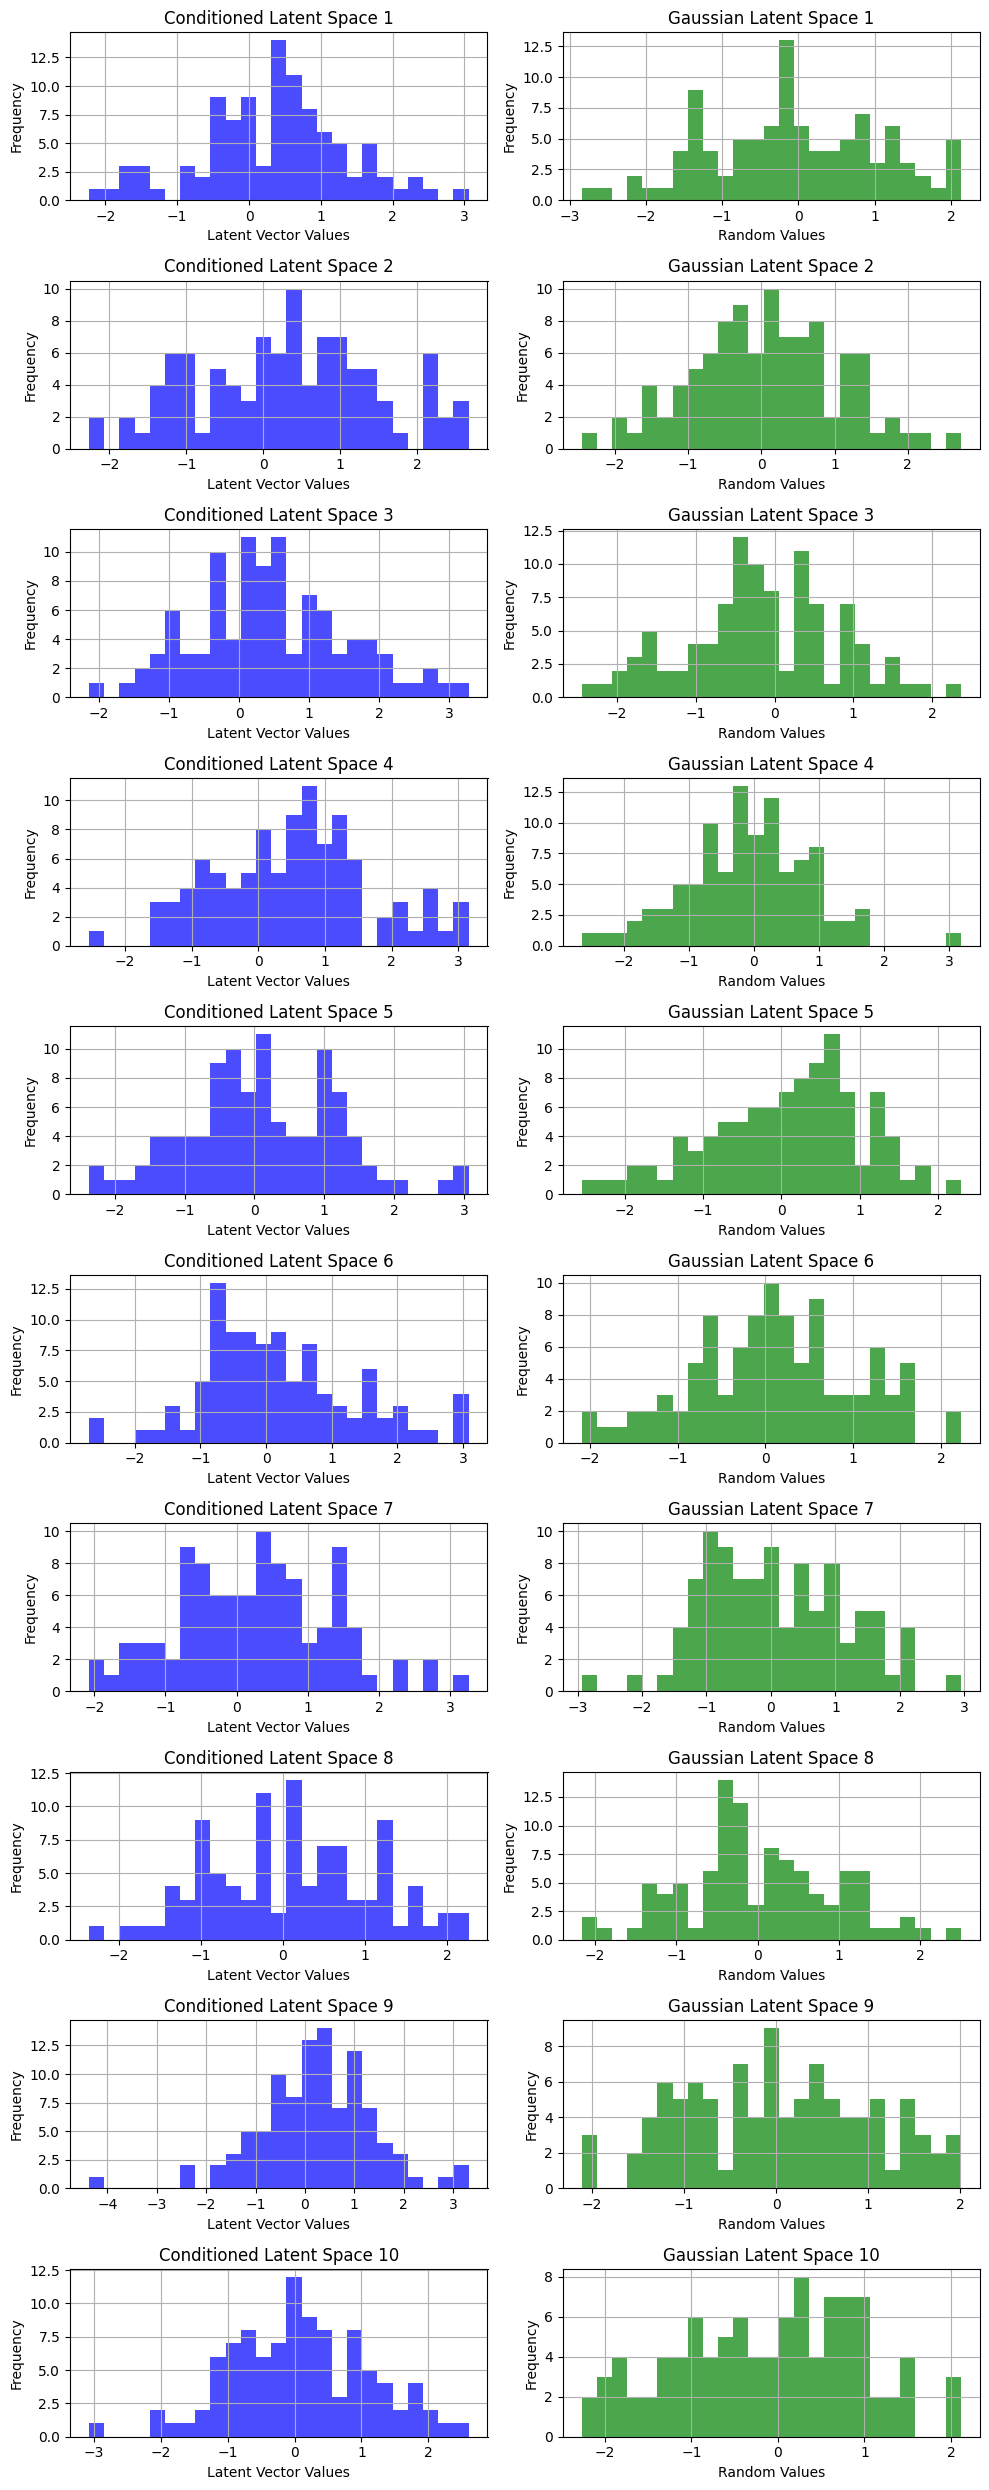

In [ ]:
# Plot the histograms

fig, axes = plt.subplots(10, 2, figsize=(10, 25))

for i in range(10):
    # Plot latent vector
    axes[i, 0].hist(np.asarray(latents)[1][i], bins=25, color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Conditioned Latent Space {i+1}')
    axes[i, 0].set_xlabel('Latent Vector Values')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True)

    # Plot random distribution
    axes[i, 1].hist(np.random.randn(100), bins=25, color='green', alpha=0.7)
    axes[i, 1].set_title(f'Gaussian Latent Space {i+1}')
    axes[i, 1].set_xlabel('Random Values')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#Load Realizations resulting from Conditioning

Realisations = np.load('Conditioning Statistics/realisations.npz')
data= Realisations
arrays = [data[name] for name in data.files]

# Option 1: Stack arrays to create a new dimension
final_array_stack = np.stack(arrays, axis=0)

# Option 2: Concatenate arrays along an existing axis (e.g., axis=0)
# This assumes the arrays are compatible for concatenation along this axis
final_array_concat = np.concatenate(arrays, axis=0)

# Close the file
data.close()

# Choose which final array to use based on your needs
# For demonstration, let's proceed with final_array_stack
final_array = final_array_stack

# Load the CSV file
file_path = 'Conditioning Statistics/Locations.csv'
locations_df = pd.read_csv(file_path)

# Assuming the CSV has columns named 'x' and 'y' for the coordinates
# Convert these columns into tuples and store them in a list
locations_list = list(zip(locations_df['0'], locations_df['1']))
all_locations= locations_list

#### Entropy for Uncertainty Quantification 

Entropy is used to assess the diversity of GAN-generated conditioned realizations by measuring the randomness or variability in pixel values across multiple images. High entropy at a pixel location indicates a wide range of values generated by the model, reflecting greater diversity and a more robust capture of the underlying data distribution. Conversely, low entropy suggests uniformity and potential overfitting. By evaluating entropy across all pixels, one can ensure that the GAN produces varied and diverse outputs, crucial for accurately reflecting the complexity of the training data.

In [ ]:
# Assuming final_array is a 4D numpy array with shape [number_of_vectors, number_of_images, height, width]
entropy_matrices = []
for i in range(final_array.shape[0]):  # Iterate over the first dimension, which indexes the vectors
    images = final_array[i]  # Access the i-th vector of images
    entropy_matrix = calculate_pixelwise_entropy(images)
    entropy_matrices.append(entropy_matrix)



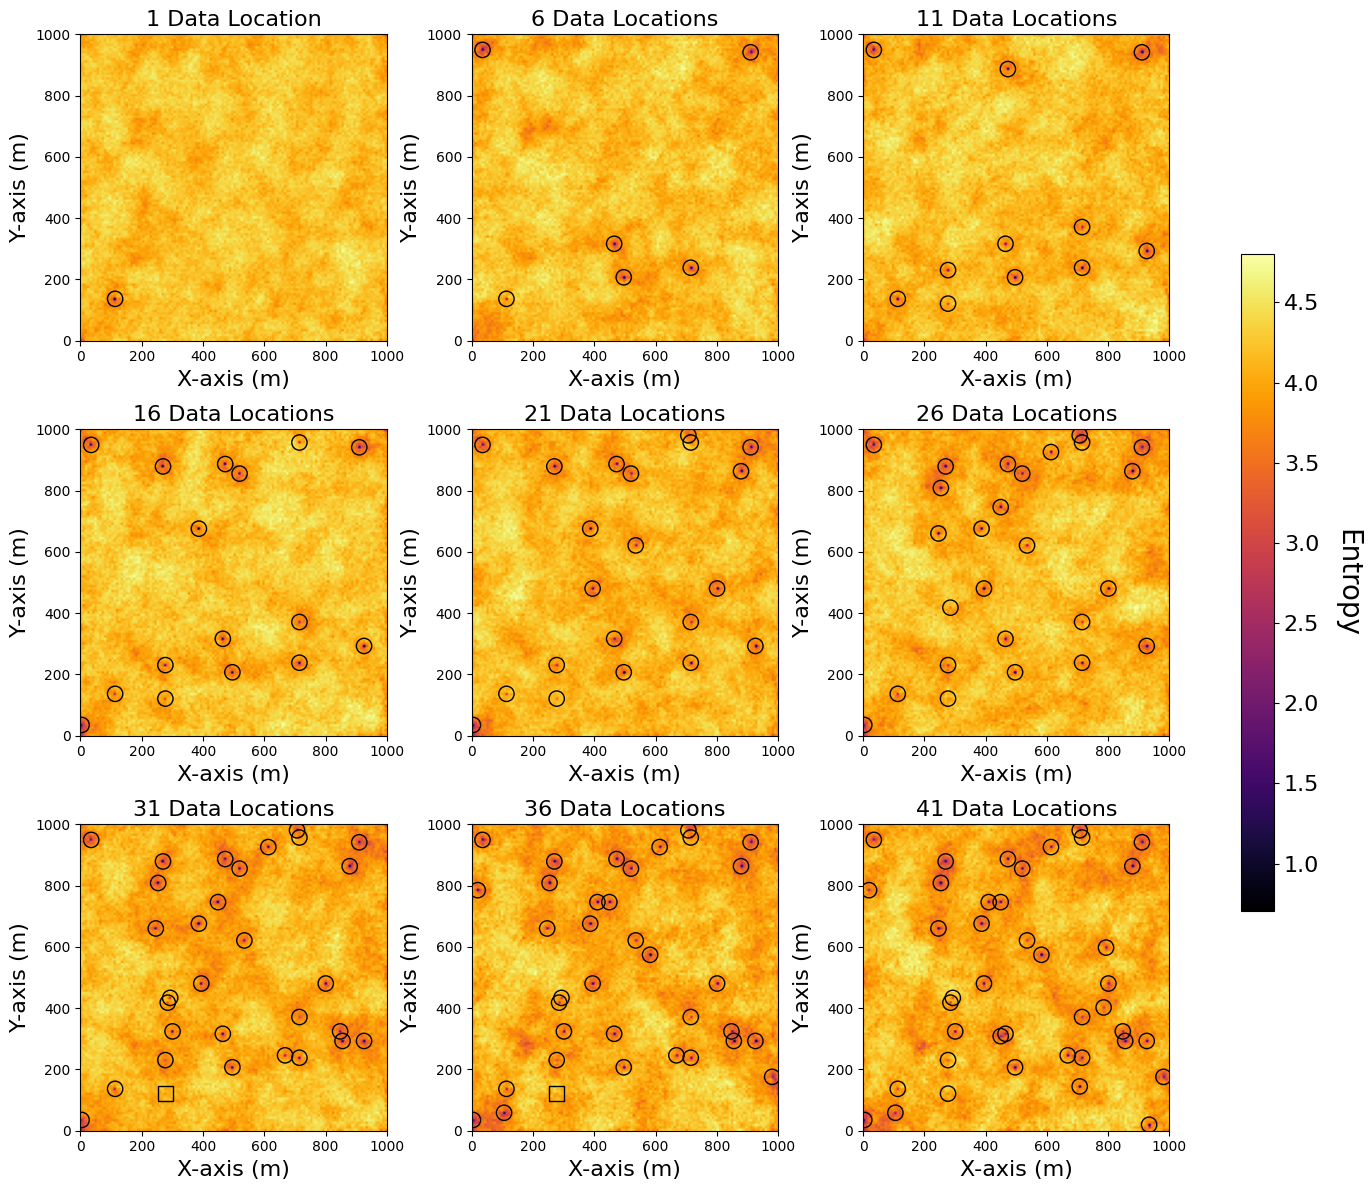

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Polygon

# Assuming 'entropy_matrices' and 'all_locations' are defined
# Setup for a 3x3 grid figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes for iteration
axes_flat = axes.flatten()
locations = all_locations
i = 0
for idx, num_points in enumerate(range(1, 42, 5)):
    if idx < 9:  # Ensure we do not exceed the 3x3 grid
        ax = axes_flat[idx]
        img_entropy = entropy_matrices[i]  # Assuming this is a numpy array
        original_height, original_width = img_entropy.shape
        img = ax.imshow(img_entropy, cmap='inferno', extent=[0, 1000, 0, 1000])
        
        p10, p50, p90 = np.percentile(img_entropy, [10, 50, 90])

        for (y, x) in locations[:num_points]:
            scaled_x = ((x + 0.5) / original_width) * 1000
            scaled_y = 1000 - ((y + 0.5) / original_height) * 1000

            pixel_value = img_entropy[y, x]
            if pixel_value < p10:
                shape = plt.Circle((scaled_x, scaled_y), radius=25, color='black', fill=False, linewidth=1)
            elif p10 <= pixel_value < p50:
                # Draw a rectangle for values between P10 and P50
                shape = Rectangle((scaled_x-25, scaled_y-25), 50, 50, color='black', fill=False, linewidth=1)
            else:
                # Draw a triangle for values above P50
                triangle_points = [(scaled_x, scaled_y + 30), (scaled_x - 26, scaled_y - 15), (scaled_x + 26, scaled_y - 15)]
                shape = Polygon(triangle_points, color='black', fill=False, linewidth=1)
            
            ax.add_patch(shape)

        ax.set_xlabel('X-axis (m)', fontsize=16)
        ax.set_ylabel('Y-axis (m)', fontsize=16)

        if i == 0:
            ax.set_title(f'{num_points} Data Location', fontsize=16)
        else:
            ax.set_title(f'{num_points} Data Locations', fontsize=16)

        i += 1

plt.tight_layout()
cbar = fig.colorbar(img, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Entropy', size=20, labelpad=30,rotation=270)
plt.show()


#### Standard Deviation for Uncertainty Quantification 

By-pixel standard deviation is used to calculate the variability in pixel values across multiple GAN-generated images. Higher standard deviation at a specific pixel location indicates greater variation, suggesting that the model produces a diverse range of outputs at that point. Conversely, lower standard deviation implies more consistent values, which may indicate less diversity in the generated images. By analyzing pixel-wise standard deviation, we can assess the extent to which the GAN captures the underlying complexity and variability of the data in its generated outputs.

In [ ]:
# Assuming final_array is a 4D numpy array with shape [number_of_vectors, number_of_images, height, width]
entropy_matrices = []
for i in range(final_array.shape[0]):  # Iterate over the first dimension, which indexes the vectors
    images = final_array[i]  # Access the i-th vector of images
    entropy_matrix = (images).std(axis=0)
    entropy_matrices.append(entropy_matrix)

# Check the shape of one of the matrices to confirm operation completion
entropy_matrices[0].shape, len(entropy_matrices)


((128, 128), 9)

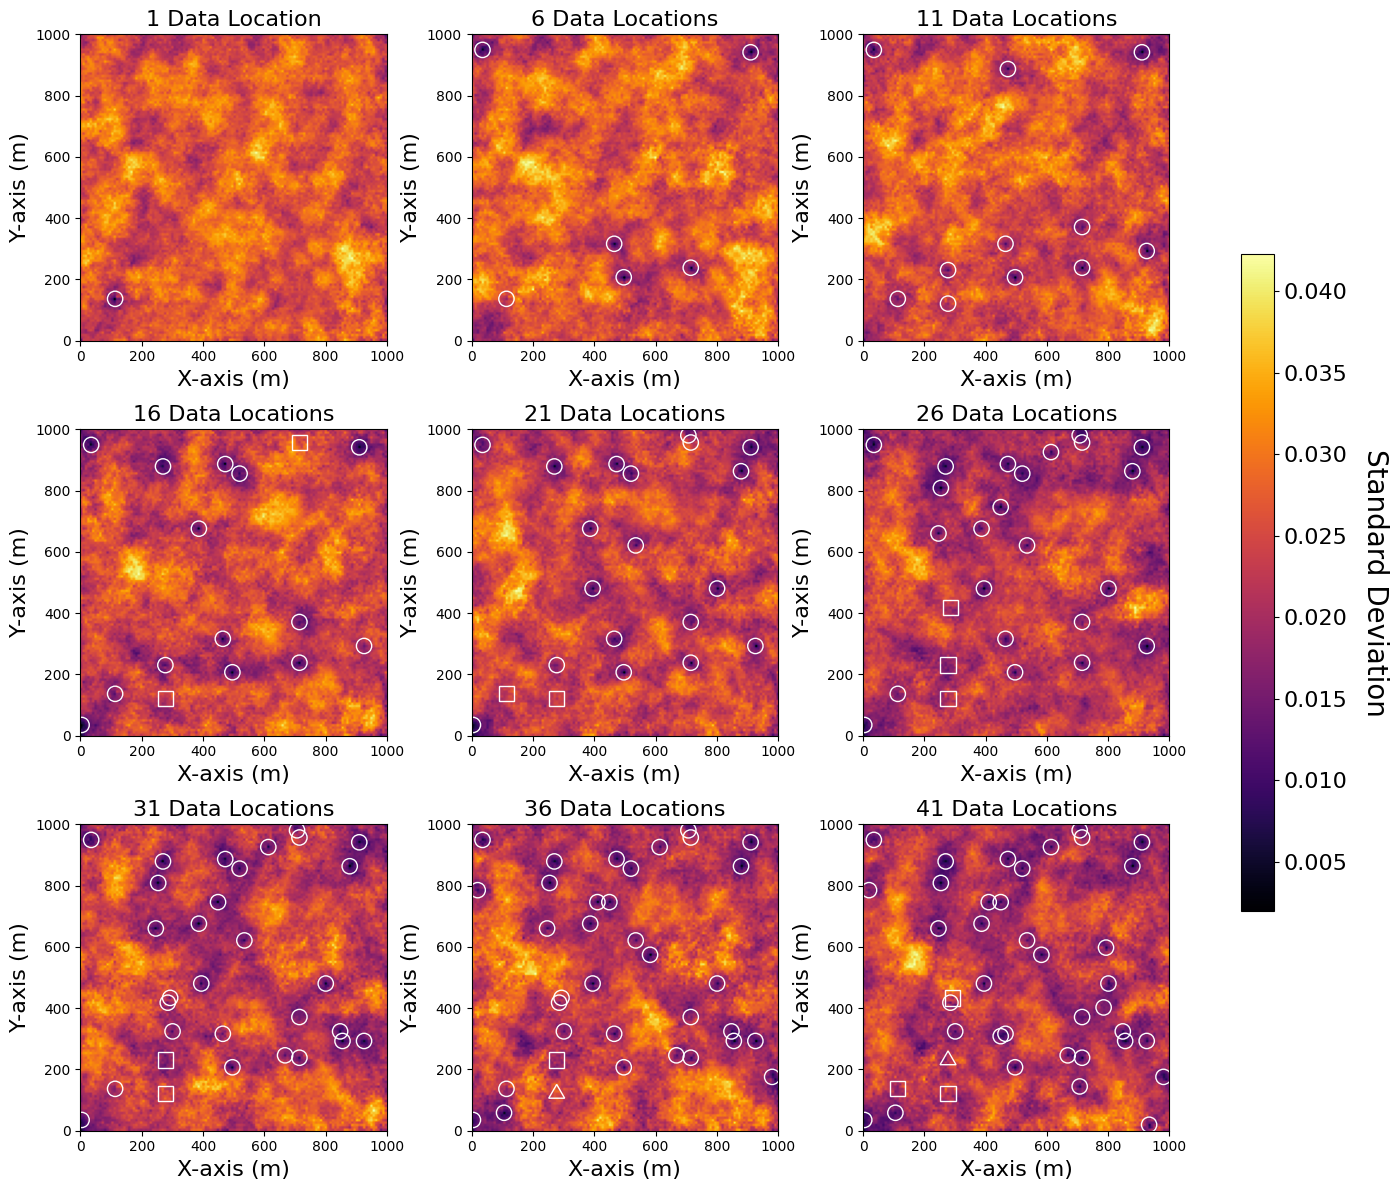

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Polygon

# Assuming 'entropy_matrices' and 'all_locations' are defined
# Setup for a 3x3 grid figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes for iteration
axes_flat = axes.flatten()
locations = all_locations
i = 0
for idx, num_points in enumerate(range(1, 42, 5)):
    if idx < 9:  # Ensure we do not exceed the 3x3 grid
        ax = axes_flat[idx]
        img_entropy = entropy_matrices[i]  # Assuming this is a numpy array
        original_height, original_width = img_entropy.shape
        img = ax.imshow(img_entropy, cmap='inferno', extent=[0, 1000, 0, 1000])
        
        p10, p50, p90 = np.percentile(img_entropy, [10, 50, 90])

        for (y, x) in locations[:num_points]:
            scaled_x = ((x + 0.5) / original_width) * 1000
            scaled_y = 1000 - ((y + 0.5) / original_height) * 1000

            pixel_value = img_entropy[y, x]
            if pixel_value < p10:
                shape = plt.Circle((scaled_x, scaled_y), radius=25, color='white', fill=False, linewidth=1)
            elif p10 <= pixel_value < p50:
                # Draw a rectangle for values between P10 and P50
                shape = Rectangle((scaled_x-25, scaled_y-25), 50, 50, color='white', fill=False, linewidth=1)
            else:
                # Draw a triangle for values above P50
                triangle_points = [(scaled_x, scaled_y + 30), (scaled_x - 26, scaled_y - 15), (scaled_x + 26, scaled_y - 15)]
                shape = Polygon(triangle_points, color='white', fill=False, linewidth=1)
            
            ax.add_patch(shape)

        ax.set_xlabel('X-axis (m)', fontsize=16)
        ax.set_ylabel('Y-axis (m)', fontsize=16)

        if i == 0:
            ax.set_title(f'{num_points} Data Location', fontsize=16)
        else:
            ax.set_title(f'{num_points} Data Locations', fontsize=16)

        i += 1

plt.tight_layout()
cbar = fig.colorbar(img, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Standard Deviation', size=20, labelpad=30,rotation=270)
plt.show()


In [ ]:
#Load Saved Conditioned points 

# Load the 'Real.pkl' file
real_data = pd.read_pickle("Conditioning Statistics/Real.pkl")

# Load the 'Predictions.pkl' file
predictions_data = pd.read_pickle("Conditioning Statistics/Predictions.pkl")

Real = real_data
Predictions = predictions_data

Training_ = np.load('Training Images/my_data200.npz')

# Extract all images from the new file and combine them into one tensor
Training_I = [Training_[key] for key in Training_]
Training_Images = np.stack(Training_I).squeeze()

#### Truth Plot

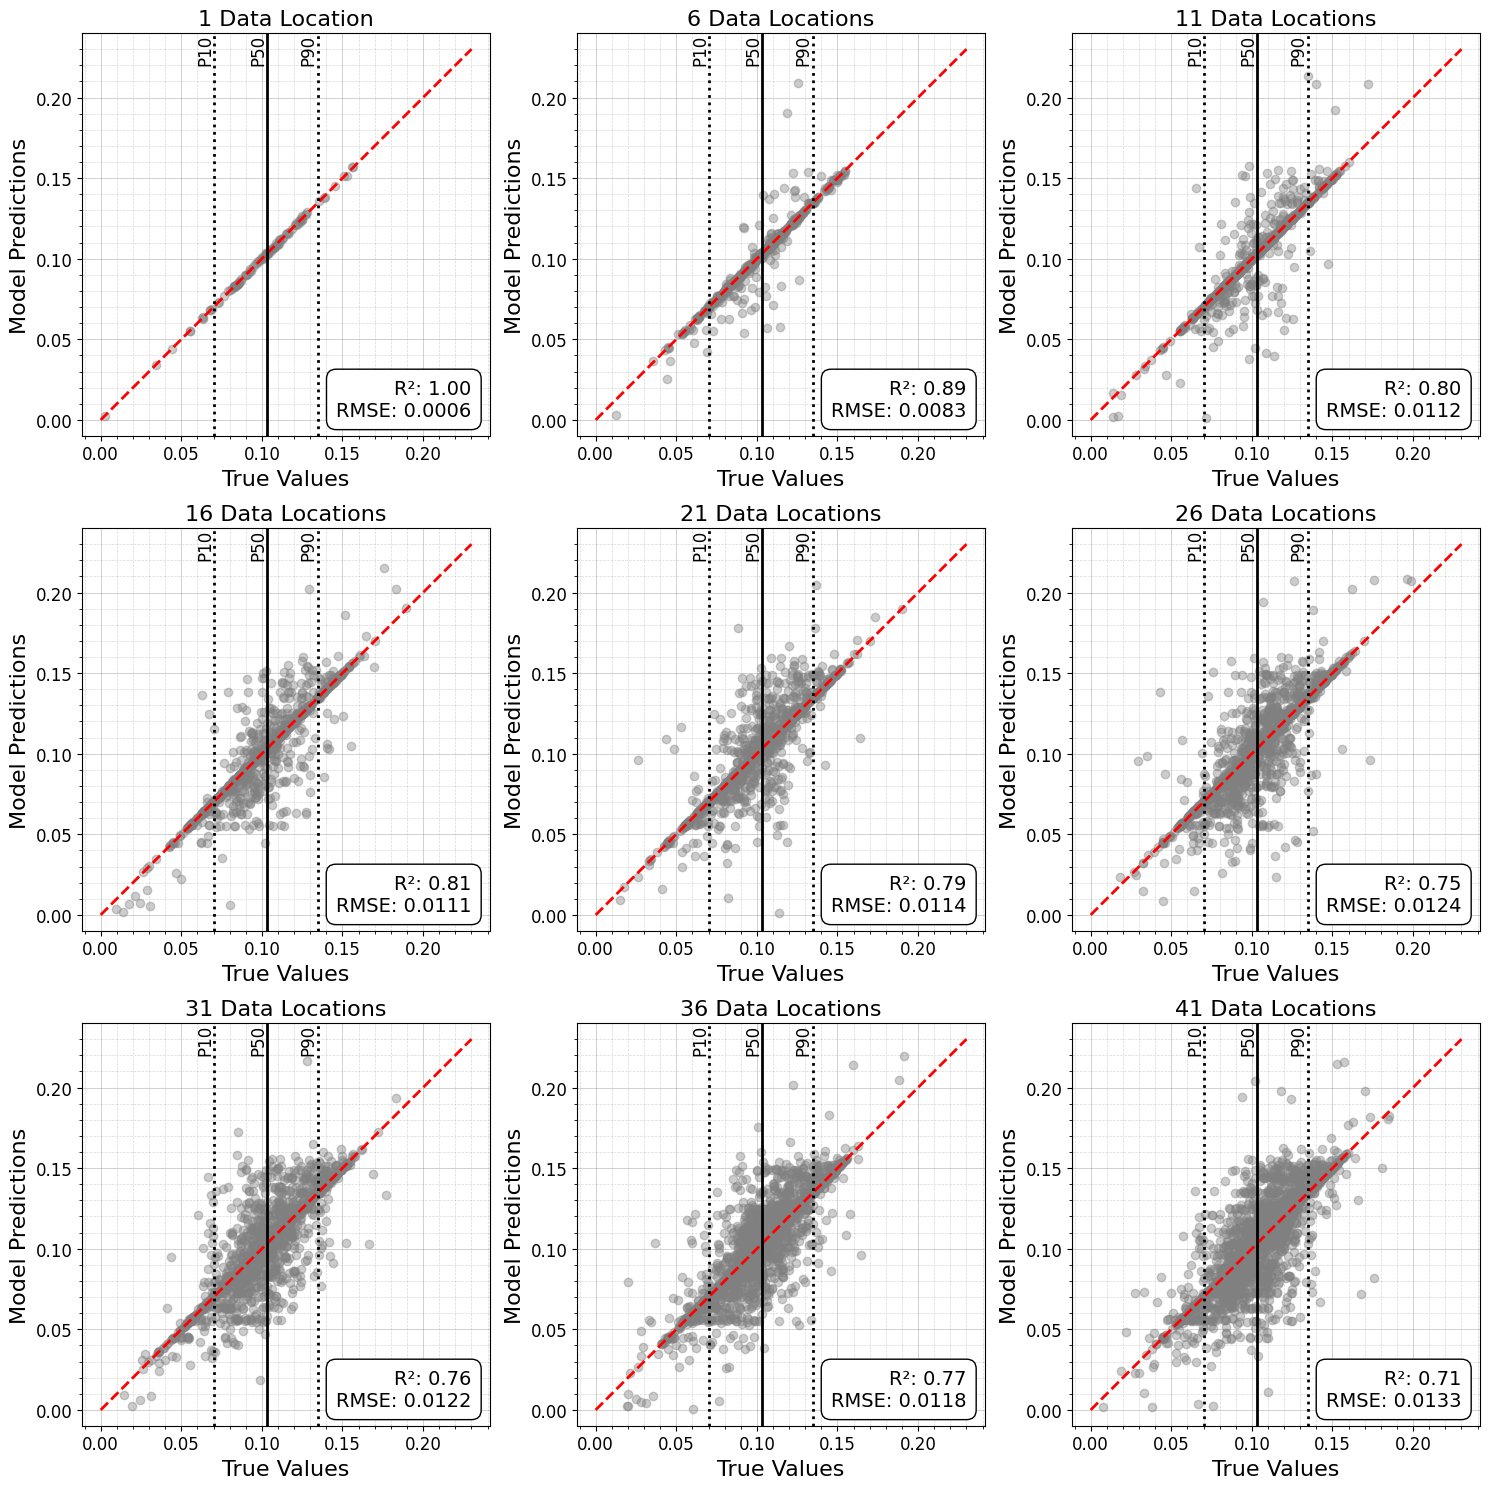

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming Predictions and Real are defined as per your earlier code

# Calculate percentiles for the Training_Images
p10 = np.percentile(Training_Images, 10)
p50 = np.percentile(Training_Images, 50)
p90 = np.percentile(Training_Images, 90)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Prepare figure for plotting
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

# Determine unified axis range and ticks
axis_min = 0
axis_max = 0.23
ticks = np.arange(axis_min, axis_max , 0.05)

# Iterate over groups
for i in range(9):
    ax = axs[i]
    y_true = np.array(Real[i])
    y_pred = np.array(Predictions[i])
    
    # Calculate metrics for the current group
    mse, rmse, r2 = calculate_metrics(y_true, y_pred)
    
    # Scatter plot of the true vs predicted values
    ax.scatter(y_pred, y_true, alpha=0.4, color='grey')
    
    # Plot a 45-degree reference line across the entire figure
    ax.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=2)
    
    # Add vertical lines for percentiles
    ax.axvline(p10, color='black', linestyle=':', linewidth=2)
    ax.axvline(p50, color='black', linestyle='-', linewidth=2)
    ax.axvline(p90, color='black', linestyle=':', linewidth=2)

    # Annotate percentile lines and add metrics to the plot
    ax.text(p10, 0.22, 'P10', verticalalignment='bottom', horizontalalignment='right', color='black', fontsize=12,rotation=90)
    ax.text(p50, 0.22, 'P50', verticalalignment='bottom', horizontalalignment='right', color='black', fontsize=12,rotation=90)
    ax.text(p90, 0.22, 'P90', verticalalignment='bottom', horizontalalignment='right', color='black', fontsize=12,rotation=90)
    metrics_text = f'R²: {r2:.2f}\nRMSE: {rmse:.4f}'
    ax.text(axis_max, axis_min, metrics_text, verticalalignment='bottom', horizontalalignment='right', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Set title, axis labels, unified axis limits and ticks
    if i==0:
        ax.set_title(f'{i*5+1} Data Location', fontsize=16)
    else:
        ax.set_title(f'{i*5+1} Data Locations', fontsize=16)
        
    ax.set_xlabel('True Values', fontsize=16)
    ax.set_ylabel('Model Predictions', fontsize=16)
    ax.set_xlim([axis_min, axis_max])
    ax.set_ylim([axis_min, axis_max])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')
    
    ax.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    ax.minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)


plt.tight_layout()
plt.show()


#### Loading Results

The following code deals with the results from a previous conditioning process. The conditioning process is computationally intensive and time-consuming, so it was performed earlier. The results were saved in `.npz` files and are now being loaded and used to demonstrate the outcomes of that process.


In [ ]:
import numpy as np

# Load and organize all_errors data
data = np.load('Conditioning Statistics/all_errors_.npz')
all_errors = [data[key] for key in data.files]

# Load and organize all_variograms data
data = np.load('Conditioning Statistics/all_variograms_.npz')
all_variograms = [data[key] for key in data.files]

# Load and organize all_Area data
data = np.load('Conditioning Statistics/all_Area_.npz')
all_Area = [data[key] for key in data.files]

# Load and organize all_OA data
data = np.load('Conditioning Statistics/all_OA_.npz')
all_OA = [data[key] for key in data.files]

# Load and organize all_iterations data
data = np.load('Conditioning Statistics/all_iterations_.npz')
all_iterations = [data[key] for key in data.files]

# Load and organize all_variances data
data = np.load('Conditioning Statistics/all_variances_.npz')
all_variances = [data[key] for key in data.files]

# Load and organize all_neighbor_variances_away data
data = np.load('Conditioning Statistics/all_neighbor_variances_away_.npz')
all_neighbor_variances_away = [data[key] for key in data.files]


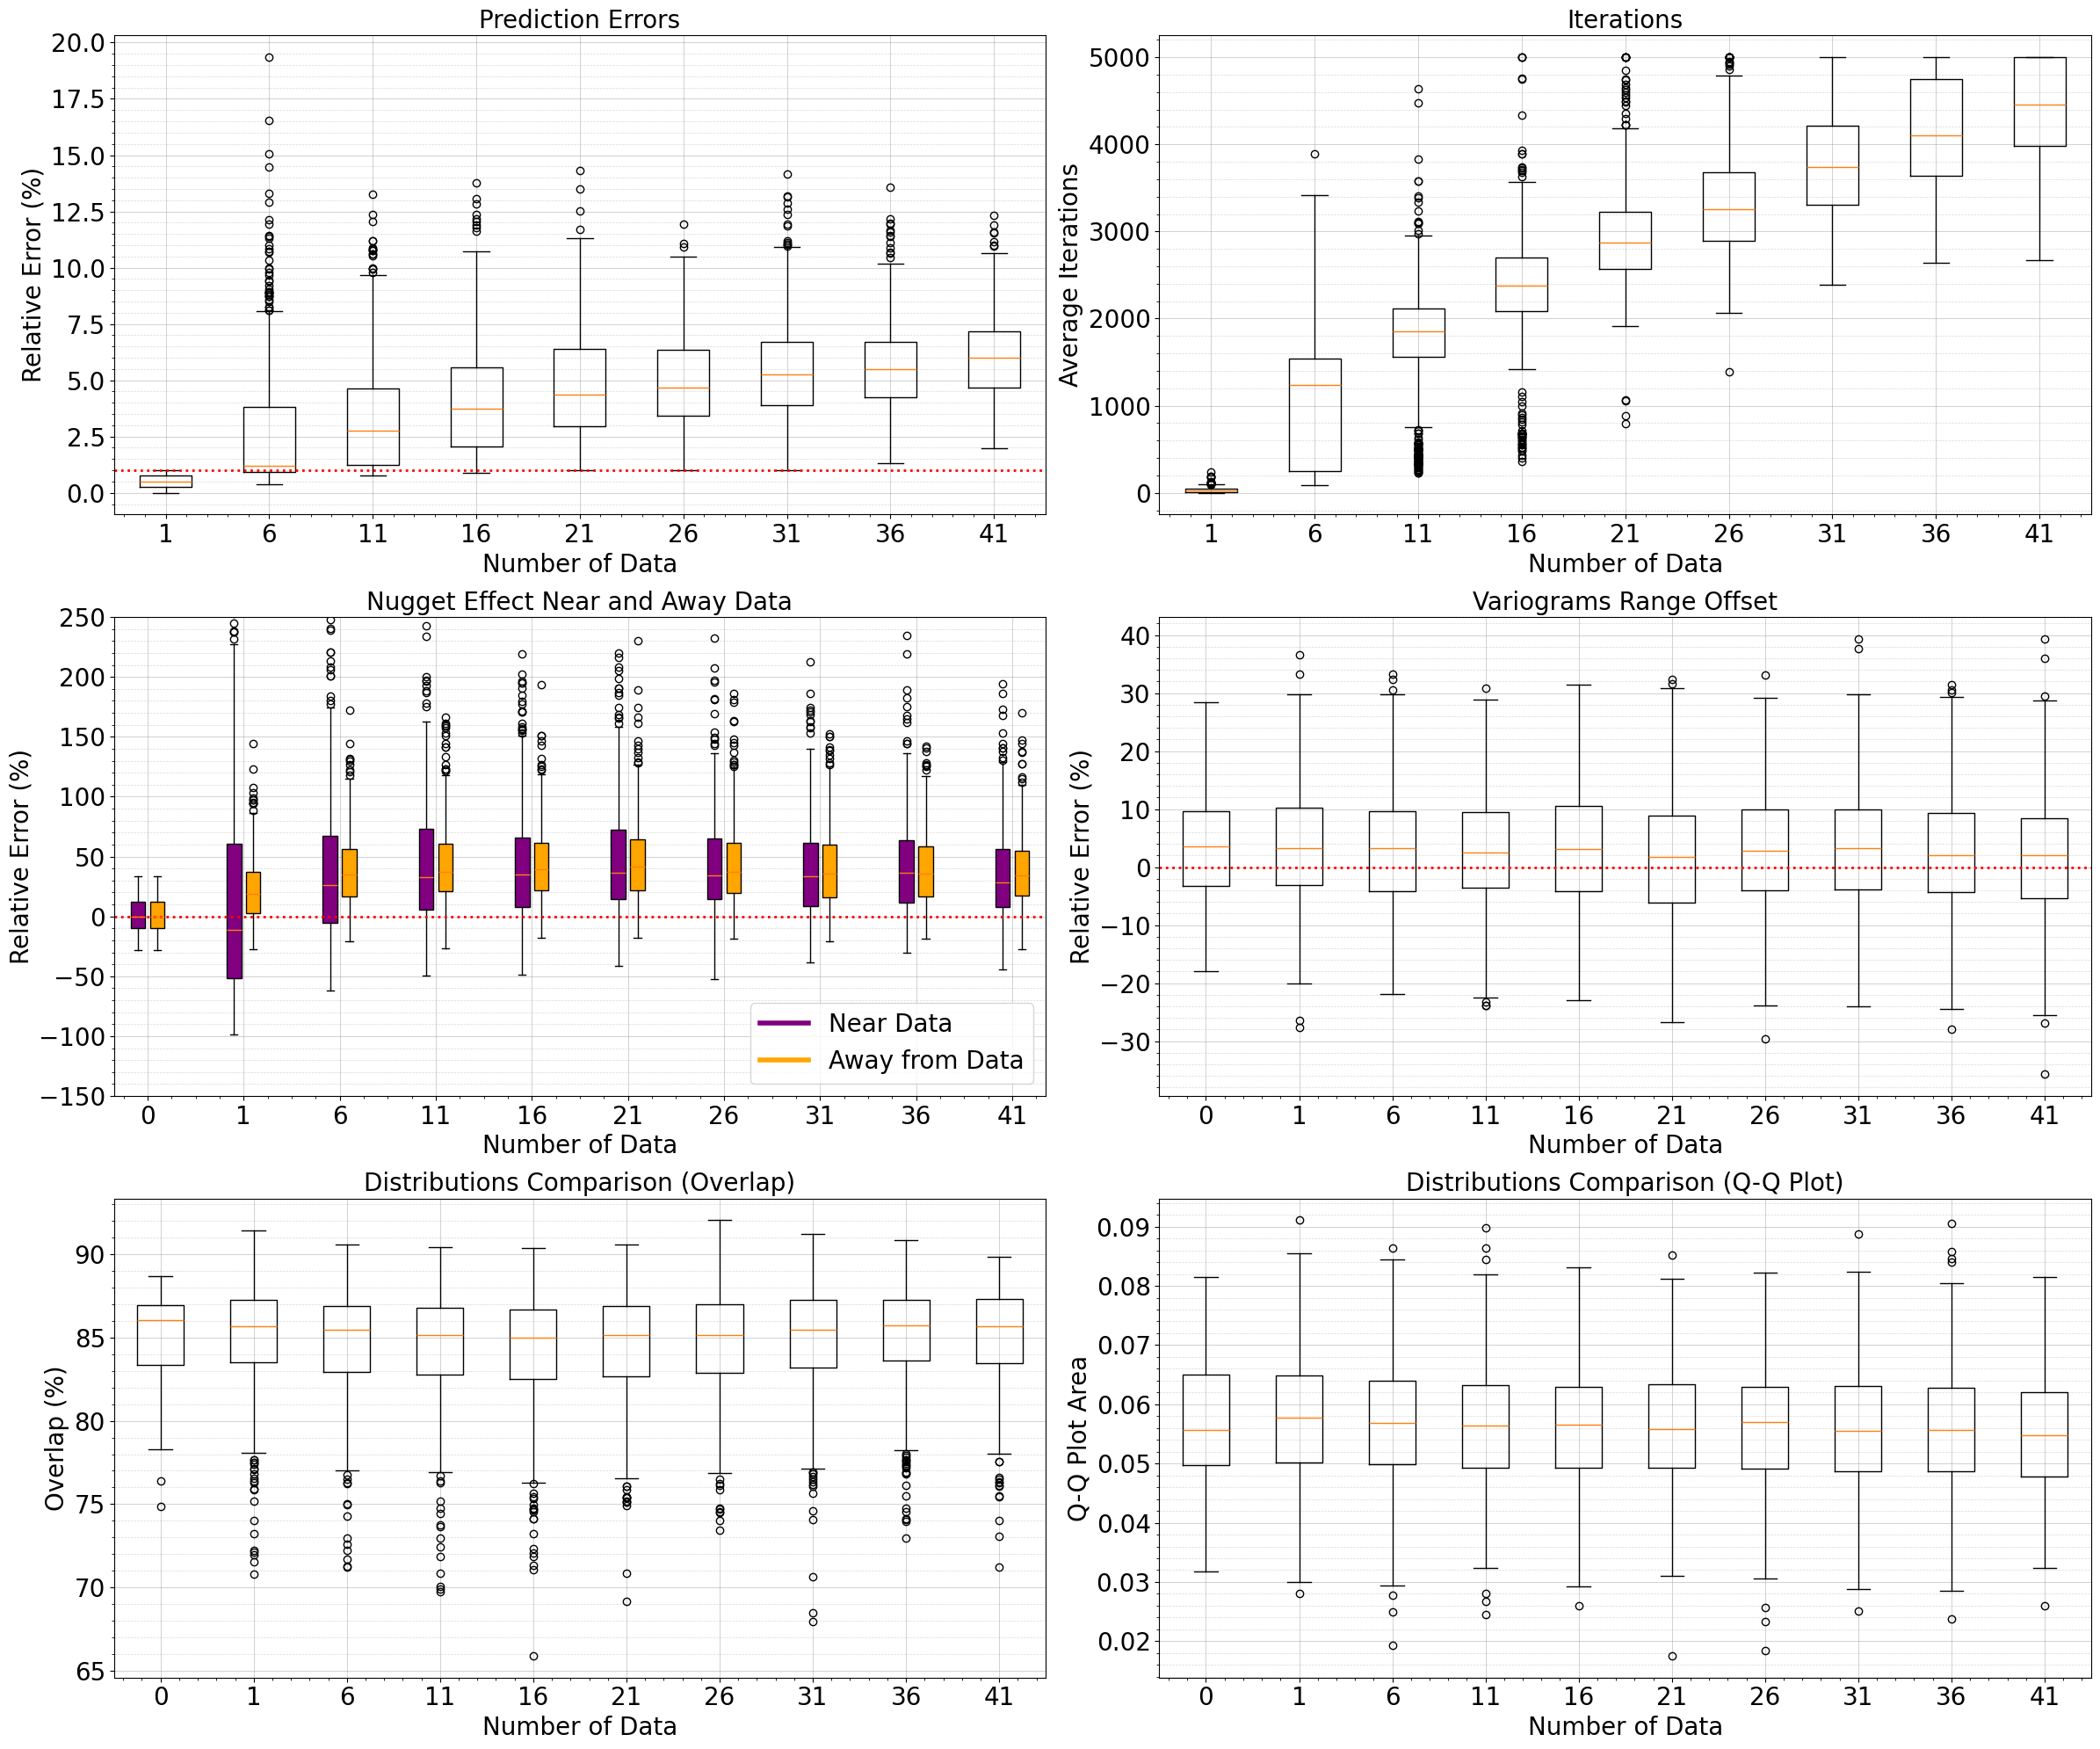

In [ ]:

# Increase the figure size for better visibility
plt.figure(figsize=(24, 20))  # Increased figure size

# Define x-tick labels for the plots
x_tick_labels_no_zero = [str(n) for n in range(1, 42, 5)]  # ['1', '6', '11', ...]
x_tick_labels_with_zero = ['0'] + x_tick_labels_no_zero

# Placeholder datasets

all_errors2 = [np.array(metric) * 100 for metric in all_errors]  # Multiply each element by 100
all_variograms2 = [np.array(metric) * 100 for metric in all_variograms]  # Multiply each element by 100
all_OA2 = [np.array(metric) * 100 for metric in all_OA]

# Helper function to adjust tick sizes
def set_tick_sizes(ax):
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(20)

# Plotting each subplot
for i, (data, xlabel, ylabel, title, xticks_labels) in enumerate([
    (all_errors2, 'Number of Data', 'Relative Error (%)', 'Prediction Errors', x_tick_labels_no_zero),
    (all_iterations, 'Number of Data', 'Average Iterations', 'Iterations', x_tick_labels_no_zero),
    (None, 'Number of Data', 'Relative Error (%)', 'Nugget Effect Near and Away Data', x_tick_labels_with_zero),  # Placeholder for custom handling
    (all_variograms2, 'Number of Data', 'Relative Error (%)', 'Variograms Range Offset', x_tick_labels_with_zero),
    (all_OA2, 'Number of Data', 'Overlap (%)', 'Distributions Comparison (Overlap)', x_tick_labels_with_zero),
    (all_Area, 'Number of Data', 'Q-Q Plot Area', 'Distributions Comparison (Q-Q Plot)', x_tick_labels_with_zero),
]):
    ax = plt.subplot(3, 2, i+1)


    if i == 2:  # Special handling for combined variance plot
        combined_variance_data = [item for sublist in zip(normalize_to_first_index(all_variances), normalize_to_first_index(all_neighbor_variances_away)) for item in sublist]
        offset_close = 0.1
        offset_away = 0.7
        positions = [x for pair in zip(np.arange(1, len(all_variances) * 2, 2) - offset_close, np.arange(2, len(all_variances) * 2 + 1, 2) - offset_away) for x in pair]
        bp = ax.boxplot(combined_variance_data, positions=positions, widths=0.3, patch_artist=True)
        colors = ['purple', 'orange'] * (len(all_variances))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        group_positions = [np.mean(pair) for pair in zip(np.arange(1, len(all_variances) * 2, 2) - offset_close, np.arange(2, len(all_variances) * 2 + 1, 2) - offset_away)]
        ax.set_xticks(group_positions)
        ax.set_xticklabels(xticks_labels[:len(group_positions)])
        ax.set_ylim(-150, 250)
        ax.axhline(y=0, color='r', linestyle=':', linewidth=2)

        # Add legend
        legend_elements = [plt.Line2D([0], [0], color='purple', lw=4, label='Near Data'),
                        plt.Line2D([0], [0], color='orange', lw=4, label='Away from Data')]
        ax.legend(handles=legend_elements, fontsize = 20)

    else:
        ax.boxplot(data)
        ax.set_xticks(range(1, len(data) + 1))
        ax.set_xticklabels(xticks_labels[:len(data)])
        if i == 0:
            ax.axhline(y=1, color='r', linestyle=':', linewidth=2)
        if i == 3:
            ax.axhline(y=0, color='r', linestyle=':', linewidth=2)


    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    set_tick_sizes(ax)

    ax.grid(True, which='minor', axis='y',color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    ax.minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)




plt.tight_layout()
plt.show()


#### Pattern Based Check 

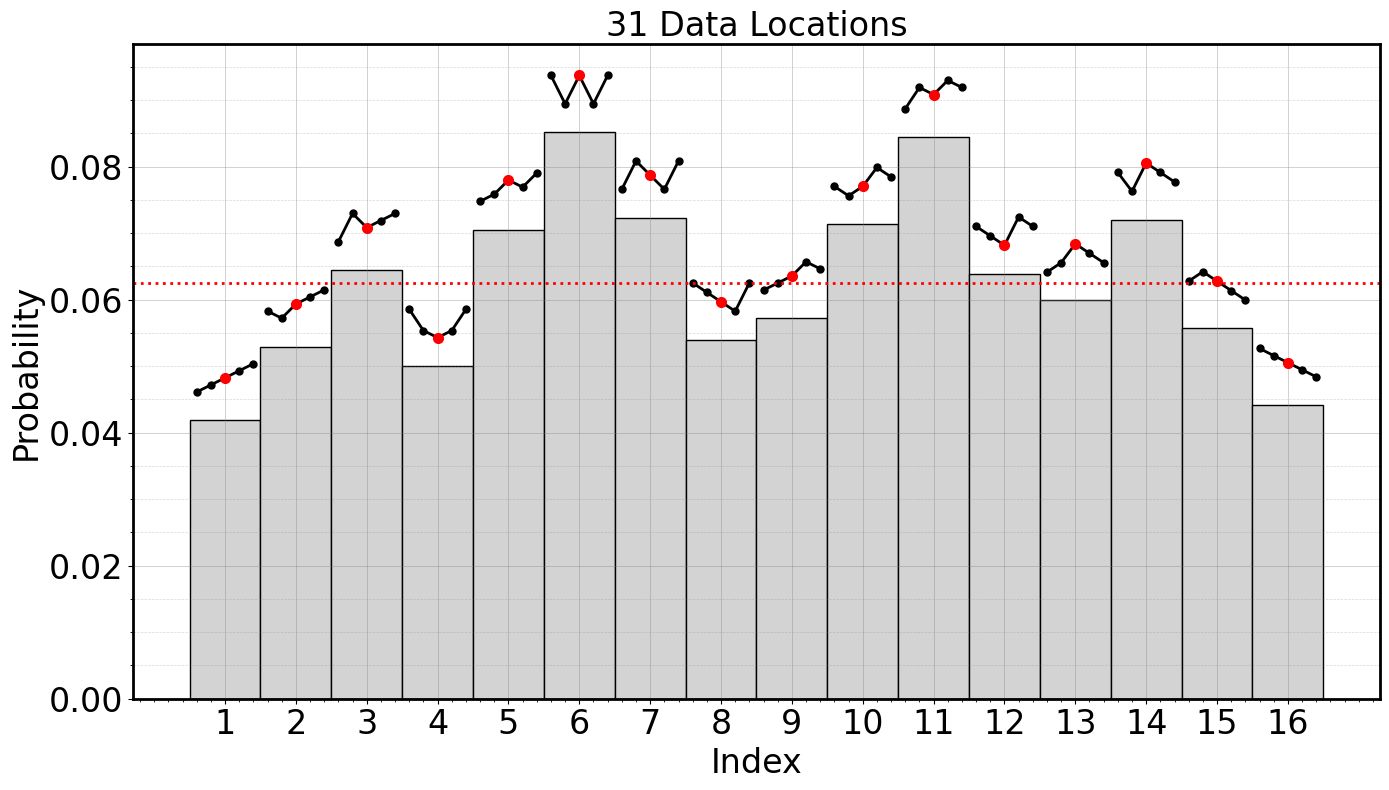

In [ ]:
flattened_list=pd.read_csv('Conditioning Statistics/histogram__31.csv')
fig, ax = plt.subplots(figsize=(14, 8))
hist_data = flattened_list.iloc[0] #flattened_list['0'] ##
bin_boundaries = np.arange(1, 18, 1)  # Adjust based on your actual data

counts, bins, patches = ax.hist(hist_data, bins=bin_boundaries, color='lightgrey', edgecolor='black', density=True)

# Plot the patterns as lines above their corresponding histogram bar, with specified color changes
for index, pattern in df.iterrows():
    # Normalize the pattern values to only show the trend (0 to 1 scale)
    normalized_pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())

    # Find the top of the corresponding histogram bar to position the pattern
    bar_height = counts[index]  # Height of the current bar
    start_y_position = bar_height + (max(counts) * 0.05)  # Slightly above the top of the bar

    # Scale the pattern y-values to fit a smaller range and position them above the bar
    scaled_pattern_y_values = normalized_pattern * (max(counts) * 0.05) + start_y_position

    # The x-values where the patterns will be plotted, centered over the bin
    bin_center = (bins[index] + bins[index + 1]) / 2
    pattern_x_values = np.linspace(bin_center - 0.4, bin_center + 0.4, len(pattern))

    # Plot the pattern above the corresponding histogram bar in black color
    ax.plot(pattern_x_values, scaled_pattern_y_values, marker='o', linestyle='-', linewidth=2, markersize=5, color='black')

    # Highlight the center node of the pattern with red color
    center_index = len(pattern) // 2  # Find the center index of the pattern
    ax.plot(pattern_x_values[center_index], scaled_pattern_y_values[center_index], marker='o', linestyle='', markersize=7, color='red')

# Enclose the boundaries of the plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Set the title and labels for the histogram
ax.set_title('31 Data Locations', fontsize=24)
ax.set_xlabel('Index', fontsize=24)
ax.set_ylabel('Probability', fontsize=24)

# Set the x-ticks to be at the center of the bins
ax.set_xticks(np.arange(1.5, 17.5, 1))
ax.tick_params(axis='y', labelsize=24)

# Customize the x-tick labels to show the indices
ax.set_xticklabels(np.arange(1, 17, 1), fontsize = 24)
ax.axhline(y=0.0625, linestyle = ':', c = 'r', linewidth = 2)
ax.grid(True, which='minor', axis = 'y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
ax.minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
# Adjust layout to prevent overlap
plt.tight_layout()
# Specify the directory and filename where you want to save the plot
# Show the composite plot
plt.show()



#### Conclusion 

We train GAN models on sequential Gaussian simulation calculations and check their performance through a novel, extended set of minimum acceptance criteria. The GAN checking workflow includes checks for distributions and spatial continuity reproduction, image comparison at lower-dimensional space, and a check for local data conditioning performance. GANs are readily able to reproduce data distributions and spatial continuity models characterized by the variogram; however, GAN models do not perform as well with local data conditioning. They result in higher errors and require more iterations to converge as the number of conditioned data locations increases. Also, GANs conditioning to local data introduces artifacts near the conditioned data locations, manifested as biased patterns characterized by an indicator-based transform index and greater variance in the experimental variogram nugget effect near data locations compared to locations away from conditioned data. 